<a id="title"></a>
# Flux Unit Conversions with synphot and stsynphot 
***
## Learning Goals
By the end of this tutorial, you will:

- Perform conversions between various systems of flux and magnitude using the `synphot` and `stsynphot` packages.
- Extrapolate an output flux at a different wavelength than the input flux, by using a spectrum defined using the same packages.
- Provide a framework to adapt a more personalized and streamlined conversion process, if desired.

## Table of Contents
[Introduction](#intro) <br>
[1. Imports](#imports) <br>
[2. Input and output setup](#input) <br>
- [2.1 Units](#unit) <br>
- [2.2 Bandpasses](#band) <br>
- [2.3 Choosing a spectrum](#spec) <br>
- [2.4 User settings](#user) <br>

[3. Set up the conversion](#setting) <br>
[4. Perform the conversion and create a plot](#perform) <br>
[5. Examples](#ex) <br>
- [5.1 Flux in Jy to AB mag with a flat spectrum in $F_\nu$](#ex1) <br>
- [5.2 Flux in flam to Flux in flam along a blackbody](#ex2) <br>
- [5.3 Flux in fnu to flux in photnu, any spectrum (same wavelength)](#ex3) <br>
- [5.4 mag to mag from an HST bandpass to a Johnson bandpass, flat spectrum in $F_\lambda$](#ex4) <br>

[6. Conclusions](#conclusion) <br>
[Additional Resources](#resources) <br>
[About the Notebook](#about) <br>
[Citations](#cite) <br>

<a id="intro"></a>
## Introduction
This notebook is based on the prior "HST Photometric Conversion Tool" that returns unit conversions between various flux units and magnitude systems. It is not intended to replace more detailed functionality such as that provided by the [Exposure Time Calculator](https://etc.stsci.edu/) (ETC). Rather, it is intended to provide a simple, quick result for flux unit conversions.

`stsynphot` requires access to data distributed by the [Calibration Data Reference System](https://hst-crds.stsci.edu/) (CRDS) in order to operate. Both packages look for an environment variable called `PYSYN_CDBS` to find the directory containing these data.

Users can obtain these data files from the CDRS. Information on how to obtain the most up-to-date reference files (and what they contain) can be found [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/synphot-throughput-tables). An example of how to download these files using `curl` and set up this environment variable is presented in the imports section below.

For detailed instructions on how to install and set up these packages, see the [synphot](https://synphot.readthedocs.io/en/latest/#installation-and-setup) and [stsynphot](https://stsynphot.readthedocs.io/en/latest/#installation-and-setup) documentation.

<a id="imports"></a>
## 1. Imports

This notebook assumes you have created the virtual environment in [WFC3 notebooks’](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/README.md) installation instructions.

We import:
- *os* for setting environment variables
- *tarfile* for extracting a .tar archive

- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data

- *synphot* and *stsynphot* for evaluating synthetic photometry
- *astropy.units* and *synphot.units* for handling units

Additionally, we will need to set the `PYSYN_CDBS` environment variable *before* importing stsynphot. We will also create a Vega spectrum using synphot's inbuilt `from_vega()` method, as the latter package will supercede this method's functionality and require a downloaded copy of the latest Vega spectrum to be provided.

In [1]:
import os
import tarfile

import numpy as np
import matplotlib.pyplot as plt

from synphot import SourceSpectrum
from synphot.models import BlackBody1D, PowerLawFlux1D
from synphot.units import convert_flux

from astropy import units as u
from synphot import units as su

%matplotlib inline
vegaspec = SourceSpectrum.from_vega() 

This section obtains the WFC3 throughput component tables for use with `stsynphot`. This step only needs to be done once. If these reference files have already been downloaded, this section can be skipped.

In [2]:
!curl -O https://archive.stsci.edu/hlsps/reference-atlases/hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  796M    0 2448k    0     0  2275k      0  0:05:58  0:00:01  0:05:57 2275k

  0  796M    0 5952k    0     0  2946k      0  0:04:36  0:00:02  0:04:34 2946k

  0  796M    0 7648k    0     0  2517k      0  0:05:23  0:00:03  0:05:20 2516k

  1  796M    1 8768k    0     0  2148k      0  0:06:19  0:00:04  0:06:15 2147k

  1  796M    1 9728k    0     0  1935k      0  0:07:01  0:00:05  0:06:56 1943k

  1  796M    1 10.5M    0     0  1793k      0  0:07:34  0:00:06  0:07:28 1688k

  1  796M    1 11.3M    0     0  1654k      0  0:08:12  0:00:07  0:08:05 1133k

  1  796M    1 12.0M    0     0  1541k      0  0:08:48  0:00:08  0:08:40  947k

  1  796M    1 12.8M    0     0  1461k      0  0:09:17  0:00:09  0:09:08  895k

  1  796M    1 13.5M    0     0  1376k      0  0:09:52  0:00:10  0:09:42  816k

  1  796M    1 14.1M    0     0  1313k      0  0:10:20  0:00:11  0:10:09  738k

  1  796M    1 14.9M    0     0  1271k      0  0:10:41  0:00:12  0:10:29  736k

  1  796M    1 15.5M    0     0  1225k      0  0:11:05  0:00:13  0:10:52  715k

  2  796M    2 16.2M    0     0  1184k      0  0:11:28  0:00:14  0:11:14  684k

  2  796M    2 16.9M    0     0  1153k      0  0:11:47  0:00:15  0:11:32  704k

  2  796M    2 17.6M    0     0  1128k      0  0:12:02  0:00:16  0:11:46  717k

  2  796M    2 18.5M    0     0  1113k      0  0:12:12  0:00:17  0:11:55  733k

  2  796M    2 19.5M    0     0  1108k      0  0:12:15  0:00:18  0:11:57  809k

  2  796M    2 20.2M    0     0  1089k      0  0:12:28  0:00:19  0:12:09  820k

  2  796M    2 20.7M    0     0  1063k      0  0:12:46  0:00:20  0:12:26  793k

  2  796M    2 21.5M    0     0  1047k      0  0:12:58  0:00:21  0:12:37  785k

  2  796M    2 22.2M    0     0  1033k      0  0:13:08  0:00:22  0:12:46  759k

  2  796M    2 22.6M    0     0  1007k      0  0:13:29  0:00:23  0:13:06  638k

  2  796M    2 23.2M    0     0   989k      0  0:13:44  0:00:24  0:13:20  611k

  2  796M    2 23.7M    0     0   972k      0  0:13:58  0:00:25  0:13:33  607k

  3  796M    3 24.3M    0     0   956k      0  0:14:12  0:00:26  0:13:46  575k

  3  796M    3 24.9M    0     0   943k      0  0:14:24  0:00:27  0:13:57  543k

  3  796M    3 25.5M    0     0   934k      0  0:14:32  0:00:28  0:14:04  596k

  3  796M    3 26.1M    0     0   922k      0  0:14:43  0:00:29  0:14:14  600k

  3  796M    3 26.6M    0     0   908k      0  0:14:57  0:00:30  0:14:27  589k

  3  796M    3 27.0M    0     0   892k      0  0:15:13  0:00:31  0:14:42  561k

  3  796M    3 27.5M    0     0   880k      0  0:15:25  0:00:32  0:14:53  542k

  3  796M    3 28.0M    0     0   868k      0  0:15:38  0:00:33  0:15:05  498k

  3  796M    3 28.5M    0     0   857k      0  0:15:51  0:00:34  0:15:17  478k

  3  796M    3 29.0M    0     0   850k      0  0:15:59  0:00:35  0:15:24  496k

  3  796M    3 29.6M    0     0   843k      0  0:16:06  0:00:36  0:15:30  538k

  3  796M    3 30.3M    0     0   839k      0  0:16:10  0:00:37  0:15:33  578k

  3  796M    3 31.2M    0     0   841k      0  0:16:09  0:00:38  0:15:31  661k

  4  796M    4 32.2M    0     0   845k      0  0:16:04  0:00:39  0:15:25  764k

  4  796M    4 33.0M    0     0   846k      0  0:16:03  0:00:40  0:15:23  822k

  4  796M    4 34.1M    0     0   851k      0  0:15:57  0:00:41  0:15:16  909k

  4  796M    4 35.2M    0     0   858k      0  0:15:49  0:00:42  0:15:07  998k

  4  796M    4 36.5M    0     0   869k      0  0:15:37  0:00:43  0:14:54 1088k

  4  796M    4 37.5M    0     0   873k      0  0:15:32  0:00:44  0:14:48 1096k

  4  796M    4 38.3M    0     0   871k      0  0:15:35  0:00:45  0:14:50 1068k

  4  796M    4 38.8M    0     0   864k      0  0:15:42  0:00:46  0:14:56  974k

  4  796M    4 39.5M    0     0   861k      0  0:15:46  0:00:47  0:14:59  881k

  5  796M    5 40.4M    0     0   860k      0  0:15:47  0:00:48  0:14:59  786k

  5  796M    5 41.4M    0     0   863k      0  0:15:43  0:00:49  0:14:54  776k

  5  796M    5 42.4M    0     0   869k      0  0:15:37  0:00:50  0:14:47  852k

  5  796M    5 43.4M    0     0   871k      0  0:15:35  0:00:51  0:14:44  937k

  5  796M    5 44.5M    0     0   877k      0  0:15:29  0:00:52  0:14:37 1032k

  5  796M    5 45.7M    0     0   881k      0  0:15:24  0:00:53  0:14:31 1082k

  5  796M    5 46.6M    0     0   883k      0  0:15:23  0:00:54  0:14:29 1075k

  5  796M    5 47.4M    0     0   882k      0  0:15:23  0:00:55  0:14:28 1012k

  6  796M    6 48.1M    0     0   878k      0  0:15:27  0:00:56  0:14:31  949k

  6  796M    6 48.8M    0     0   877k      0  0:15:29  0:00:57  0:14:32  877k

  6  796M    6 49.6M    0     0   875k      0  0:15:31  0:00:58  0:14:33  808k

  6  796M    6 50.4M    0     0   874k      0  0:15:32  0:00:59  0:14:33  782k

  6  796M    6 51.1M    0     0   872k      0  0:15:34  0:01:00  0:14:34  762k

  6  796M    6 51.9M    0     0   871k      0  0:15:35  0:01:01  0:14:34  789k

  6  796M    6 52.7M    0     0   871k      0  0:15:35  0:01:02  0:14:33  804k

  6  796M    6 53.7M    0     0   873k      0  0:15:33  0:01:03  0:14:30  854k

  6  796M    6 54.7M    0     0   876k      0  0:15:30  0:01:04  0:14:26  896k

  6  796M    6 55.4M    0     0   873k      0  0:15:33  0:01:05  0:14:28  884k

  7  796M    7 56.0M    0     0   869k      0  0:15:37  0:01:06  0:14:31  842k

  7  796M    7 56.7M    0     0   867k      0  0:15:39  0:01:07  0:14:32  819k

  7  796M    7 57.6M    0     0   867k      0  0:15:39  0:01:08  0:14:31  793k

  7  796M    7 58.4M    0     0   867k      0  0:15:39  0:01:09  0:14:30  753k

  7  796M    7 59.1M    0     0   864k      0  0:15:43  0:01:10  0:14:33  743k

  7  796M    7 59.6M    0     0   860k      0  0:15:47  0:01:11  0:14:36  735k

  7  796M    7 60.2M    0     0   856k      0  0:15:51  0:01:12  0:14:39  711k

  7  796M    7 60.9M    0     0   853k      0  0:15:54  0:01:13  0:14:41  663k

  7  796M    7 61.6M    0     0   852k      0  0:15:56  0:01:14  0:14:42  642k

  7  796M    7 62.4M    0     0   851k      0  0:15:56  0:01:15  0:14:41  681k

  7  796M    7 63.2M    0     0   852k      0  0:15:56  0:01:16  0:14:40  738k

  8  796M    8 64.1M    0     0   851k      0  0:15:57  0:01:17  0:14:40  781k

  8  796M    8 65.0M    0     0   853k      0  0:15:55  0:01:18  0:14:37  839k

  8  796M    8 65.9M    0     0   854k      0  0:15:54  0:01:19  0:14:35  885k

  8  796M    8 66.5M    0     0   851k      0  0:15:57  0:01:20  0:14:37  843k

  8  796M    8 67.0M    0     0   847k      0  0:16:01  0:01:21  0:14:40  781k

  8  796M    8 67.7M    0     0   845k      0  0:16:03  0:01:22  0:14:41  750k

  8  796M    8 68.5M    0     0   845k      0  0:16:04  0:01:23  0:14:41  726k

  8  796M    8 69.4M    0     0   846k      0  0:16:02  0:01:24  0:14:38  729k

  8  796M    8 70.5M    0     0   849k      0  0:15:59  0:01:25  0:14:34  823k

  9  796M    9 71.7M    0     0   854k      0  0:15:54  0:01:26  0:14:28  957k

  9  796M    9 72.7M    0     0   856k      0  0:15:51  0:01:27  0:14:24 1033k

  9  796M    9 73.5M    0     0   855k      0  0:15:52  0:01:28  0:14:24 1026k

  9  796M    9 74.2M    0     0   854k      0  0:15:54  0:01:29  0:14:25  975k

  9  796M    9 75.0M    0     0   853k      0  0:15:54  0:01:30  0:14:24  924k

  9  796M    9 76.0M    0     0   855k      0  0:15:53  0:01:31  0:14:22  873k

  9  796M    9 76.8M    0     0   855k      0  0:15:52  0:01:32  0:14:20  839k

  9  796M    9 77.7M    0     0   856k      0  0:15:52  0:01:33  0:14:19  863k

  9  796M    9 78.5M    0     0   855k      0  0:15:53  0:01:34  0:14:19  877k

  9  796M    9 79.2M    0     0   853k      0  0:15:55  0:01:35  0:14:20  845k

 10  796M   10 79.9M    0     0   852k      0  0:15:56  0:01:36  0:14:20  801k

 10  796M   10 80.4M    0     0   849k      0  0:16:00  0:01:37  0:14:23  728k

 10  796M   10 81.0M    0     0   846k      0  0:16:03  0:01:38  0:14:25  661k

 10  796M   10 81.6M    0     0   844k      0  0:16:05  0:01:39  0:14:26  635k

 10  796M   10 82.2M    0     0   842k      0  0:16:07  0:01:40  0:14:27  630k

 10  796M   10 82.9M    0     0   840k      0  0:16:10  0:01:41  0:14:29  607k

 10  796M   10 83.4M    0     0   837k      0  0:16:13  0:01:42  0:14:31  618k

 10  796M   10 83.9M    0     0   834k      0  0:16:17  0:01:43  0:14:34  596k

 10  796M   10 84.4M    0     0   831k      0  0:16:20  0:01:44  0:14:36  578k

 10  796M   10 85.1M    0     0   830k      0  0:16:22  0:01:45  0:14:37  586k

 10  796M   10 85.8M    0     0   829k      0  0:16:23  0:01:46  0:14:37  602k

 10  796M   10 86.5M    0     0   828k      0  0:16:24  0:01:47  0:14:37  633k

 10  796M   10 87.3M    0     0   828k      0  0:16:24  0:01:48  0:14:36  705k

 11  796M   11 88.2M    0     0   828k      0  0:16:23  0:01:49  0:14:34  769k

 11  796M   11 88.8M    0     0   826k      0  0:16:26  0:01:50  0:14:36  753k

 11  796M   11 89.3M    0     0   823k      0  0:16:29  0:01:51  0:14:38  712k

 11  796M   11 89.9M    0     0   822k      0  0:16:31  0:01:52  0:14:39  693k

 11  796M   11 90.7M    0     0   821k      0  0:16:32  0:01:53  0:14:39  680k

 11  796M   11 91.4M    0     0   820k      0  0:16:33  0:01:54  0:14:39  650k

 11  796M   11 92.0M    0     0   819k      0  0:16:34  0:01:55  0:14:39  662k

 11  796M   11 92.7M    0     0   818k      0  0:16:35  0:01:56  0:14:39  703k

 11  796M   11 93.5M    0     0   818k      0  0:16:35  0:01:57  0:14:38  743k

 11  796M   11 94.5M    0     0   820k      0  0:16:34  0:01:58  0:14:36  786k

 11  796M   11 95.4M    0     0   821k      0  0:16:32  0:01:59  0:14:33  828k

 12  796M   12 96.4M    0     0   822k      0  0:16:31  0:02:00  0:14:31  894k

 12  796M   12 97.4M    0     0   824k      0  0:16:28  0:02:01  0:14:27  965k

 12  796M   12 98.3M    0     0   825k      0  0:16:27  0:02:02  0:14:25  984k

 12  796M   12 99.2M    0     0   826k      0  0:16:26  0:02:03  0:14:23  977k

 12  796M   12  100M    0     0   826k      0  0:16:26  0:02:04  0:14:22  960k

 12  796M   12  101M    0     0   827k      0  0:16:25  0:02:05  0:14:20  940k

 12  796M   12  101M    0     0   826k      0  0:16:25  0:02:06  0:14:19  881k

 12  796M   12  102M    0     0   825k      0  0:16:27  0:02:07  0:14:20  819k

 12  796M   12  103M    0     0   824k      0  0:16:29  0:02:08  0:14:21  767k

 13  796M   13  103M    0     0   823k      0  0:16:30  0:02:09  0:14:21  740k

 13  796M   13  104M    0     0   822k      0  0:16:31  0:02:10  0:14:21  690k

 13  796M   13  105M    0     0   821k      0  0:16:32  0:02:11  0:14:21  686k

 13  796M   13  105M    0     0   819k      0  0:16:34  0:02:12  0:14:22  671k

 13  796M   13  106M    0     0   

817k      0  0:16:37  0:02:13  0:14:24  646k

 13  796M   13  106M    0     0   816k      0  0:16:38  0:02:14  0:14:24  645k

 13  796M   13  107M    0     0   814k      0  0:16:40  0:02:15  0:14:25  626k

 13  796M   13  107M    0     0   812k      0  0:16:44  0:02:16  0:14:28  561k

 13  796M   13  108M    0     0   809k      0  0:16:46  0:02:17  0:14:29  550k

 13  796M   13  108M    0     0   808k      0  0:16:48  0:02:18  0:14:30  562k

 13  796M   13  109M    0     0   808k      0  0:16:48  0:02:19  0:14:29  574k

 13  796M   13  110M    0     0   807k      0  0:16:49  0:02:20  0:14:29  613k

 13  796M   13  111M    0     0   807k      0  0:16:49  0:02:21  0:14:28  688k

 14  796M   14  112M    0     0   808k      0  0:16:48  0:02:22  0:14:26  771k

 14  796M   14  113M    0     0   809k      0  0:16:47  0:02:23  0:14:24  836k

 14  796M   14  113M    0     0   809k      0  0:16:46  0:02:24  0:14:22  855k

 14  796M   14  114M    0     0   811k      0  0:16:45  0:02:25  0:14:20  905k

 14  796M   14  115M    0     0   812k      0  0:16:42  0:02:26  0:14:16  959k

 14  796M   14  117M    0     0   815k      0  0:16:39  0:02:27  0:14:12 1014k

 14  796M   14  118M    0     0   818k      0  0:16:36  0:02:28  0:14:08 1087k

 15  796M   15  119M    0     0   822k      0  0:16:30  0:02:29  0:14:01 1202k

 15  796M   15  121M    0     0   826k      0  0:16:25  0:02:30  0:13:55 1282k

 15  796M   15  122M    0     0   830k      0  0:16:22  0:02:31  0:13:51 1338k

 15  796M   15  123M    0     0   834k      0  0:16:17  0:02:32  0:13:45 1382k

 15  796M   15  125M    0     0   836k      0  0:16:14  0:02:33  0:13:41 1355k

 15  796M   15  125M    0     0   836k      0  0:16:15  0:02:34  0:13:41 1233k

 15  796M   15  126M    0     0   834k      0  0:16:16  0:02:35  0:13:41 1064k

 15  796M   15  127M    0     0   833k      0  0:16:17  0:02:36  0:13:41  942k

 16  796M   16  127M    0     0   833k      0  0:16:18  0:02:37  0:13:41  807k

 16  796M   16  128M    0     0   831k      0  0:16:20  0:02:38  0:13:42  696k

 16  796M   16  128M    0     0   829k      0  0:16:22  0:02:39  0:13:43  635k

 16  796M   16  129M    0     0   828k      0  0:16:24  0:02:40  0:13:44  630k

 16  796M   16  130M    0     0   827k      0  0:16:25  0:02:41  0:13:44  628k

 16  796M   16  130M    0     0   827k      0  0:16:25  0:02:42  0:13:43  643k

 16  796M   16  131M    0     0   828k      0  0:16:24  0:02:43  0:13:41  713k

 16  796M   16  132M    0     0   829k      0  0:16:22  0:02:44  0:13:38  827k

 16  796M   16  133M    0     0   830k      0  0:16:21  0:02:45  0:13:36  911k

 16  796M   16  134M    0     0   832k      0  0:16:19  0:02:46  0:13:33  988k

 17  796M   17  136M    0     0   834k      0  0:16:17  0:02:47  0:13:30 1060k

 17  796M   17  137M    0     0   836k      0  0:16:15  0:02:48  0:13:27 1091k

 17  796M   17  138M    0     0   837k      0  0:16:13  0:02:49  0:13:24 1084k

 17  796M   17  139M    0     0   839k      0  0:16:10  0:02:50  0:13:20 1143k

 17  796M   17  140M    0     0   841k      0  0:16:08  0:02:51  0:13:17 1160k

 17  796M   17  141M    0     0   841k      0  0:16:08  0:02:52  0:13:16 1074k

 17  796M   17  141M    0     0   840k      0  0:16:10  0:02:53  0:13:17  981k

 17  796M   17  142M    0     0   839k      0  0:16:11  0:02:54  0:13:17  896k

 17  796M   17  143M    0     0   837k      0  0:16:14  0:02:55  0:13:19  741k

 18  796M   18  143M    0     0   835k      0  0:16:15  0:02:56  0:13:19  632k

 18  796M   18  144M    0     0   835k      0  0:16:16  0:02:57  0:13:19  622k

 18  796M   18  145M    0     0   835k      0  0:16:16  0:02:58  0:13:18  665k

 18  796M   18  145M    0     0   834k      0  0:16:17  0:02:59  0:13:18  661k

 18  796M   18  146M    0     0   833k      0  0:16:18  0:03:00  0:13:18  697k

 18  796M   18  147M    0     0   832k      0  0:16:18  0:03:01  0:13:17  724k

 18  796M   18  148M    0     0   833k      0  0:16:18  0:03:02  0:13:16  757k

 18  796M   18  148M    0     0   832k      0  0:16:18  0:03:03  0:13:15  749k

 18  796M   18  149M    0     0   831k      0  0:16:19  0:03:04  0:13:15  757k

 18  796M   18  150M    0     0   831k      0  0:16:20  0:03:05  0:13:15  780k

 18  796M   18  150M    0     0   830k      0  0:16:21  0:03:06  0:13:15  740k

 19  796M   19  151M    0     0   828k      0  0:16:24  0:03:07  0:13:17  647k

 19  796M   19  151M    0     0   826k      0  0:16:26  0:03:08  0:13:18  597k

 19  796M   19  152M    0     0   825k      0  0:16:27  0:03:09  0:13:18  598k

 19  796M   19  153M    0     0   825k      0  0:16:27  0:03:10  0:13:17  595k

 19  796M   19  153M    0     0   825k      0  0:16:28  0:03:11  0:13:17  629k

 19  796M   19  154M    0     0   824k      0  0:16:28  0:03:12  0:13:16  705k

 19  796M   19  155M    0     0   825k      0  0:16:27  0:03:13  0:13:14  781k

 19  796M   19  156M    0     0   826k      0  0:16:26  0:03:14  0:13:12  865k

 19  796M   19  157M    0     0   827k      0  0:16:24  0:03:15  0:13:09  912k

 19  796M   19  158M    0     0   827k      0  0:16:24  0:03:16  0:13:08  933k

 19  796M   19  159M    0     0   827k      0  0:16:25  0:03:17  0:13:08  907k

 20  796M   20  159M    0     0   826k      0  0:16:26  0:03:18  0:13:08  867k

 20  796M   20  160M    0     0   825k      0  0:16:27  0:03:19  0:13:08  791k

 20  796M   20  161M    0     0   825k      0  0:16:27  0:03:20  0:13:07  744k

 20  796M   20  162M    0     0   825k      0  0:16:27  0:03:21  0:13:06  749k

 20  796M   20  163M    0     0   826k      0  0:16:26  0:03:22  0:13:04  810k

 20  796M   20  163M    0     0   826k      0  0:16:26  0:03:23  0:13:03  808k

 20  796M   20  164M    0     0   825k      0  0:16:27  0:03:24  0:13:03  813k

 20  796M   20  165M    0     0   825k      0  0:16:27  0:03:25  0:13:02  831k

 20  796M   20  166M    0     0   825k      0  0:16:27  0:03:26  0:13:01  807k

 20  796M   20  166M    0     0   825k      0  0:16:27  0:03:27  0:13:00  789k

 21  796M   21  167M    0     0   826k      0  0:16:26  0:03:28  0:12:58  837k

 21  796M   21  168M    0     0   827k      0  0:16:25  0:03:29  0:12:56  910k

 21  796M   21  170M    0     0   829k      0  0:16:23  0:03:30  0:12:53  972k

 21  796M   21  171M    0     0   830k      0  0:16:21  0:03:31  0:12:50 1034k

 21  796M   21  172M    0     0   831k      0  0:16:20  0:03:32  0:12:48 1072k

 21  796M   21  173M    0     0   832k      0  0:16:19  0:03:33  0:12:46 1077k

 21  796M   21  174M    0     0   833k      0  0:16:18  0:03:34  0:12:44 1066k

 21  796M   21  175M    0     0   833k      0  0:16:17  0:03:35  0:12:42 1030k

 22  796M   22  176M    0     0   835k      0  0:16:16  0:03:36  0:12:40 1038k

 22  796M   22  177M    0     0   836k      0  0:16:14  0:03:37  0:12:37 1060k

 22  796M   22  178M    0     0   838k      0  0:16:12  0:03:38  0:12:34 1096k

 22  796M   22  179M    0     0   838k      0  0:16:12  0:03:39  0:12:33 1049k

 22  796M   22  179M    0     0   837k      0  0:16:13  0:03:40  0:12:33  988k

 22  796M   22  180M    0     0   836k      0  0:16:14  0:03:41  0:12:33  897k

 22  796M   22  181M    0     0   835k      0  0:16:15  0:03:42  0:12:33  789k

 22  796M   22  181M    0     0   834k      0  0:16:16  0:03:43  0:12:33  685k

 22  796M   22  182M    0     0   834k      0  0:16:17  0:03:44  0:12:33  667k

 23  796M   23  183M    0     0   834k      0  0:16:17  0:03:45  0:12:32  694k

 23  796M   23  184M    0     0   834k      0  0:16:16  0:03:46  0:12:30  749k

 23  796M   23  185M    0     0   835k      0  0:16:15  0:03:47  0:12:28  838k

 23  796M   23  186M    0     0   837k      0  0:16:13  0:03:48  0:12:25  954k

 23  796M   23  187M    0     0   839k      0  0:16:11  0:03:49  0:12:22 1053k

 23  796M   23  188M    0     0   839k      0  0:16:11  0:03:50  0:12:21 1062k

 23  796M   23  189M    0     0   839k      0  0:16:10  0:03:51  0:12:19 1066k

 23  796M   23  190M    0     0   840k      0  0:16:09  0:03:52  0:12:17 1055k

 24  796M   24  191M    0     0   842k      0  0:16:08  0:03:53  0:12:15 1054k

 24  796M   24  192M    0     0   844k      0  0:16:05  0:03:54  0:12:11 1079k

 24  796M   24  194M    0     0   846k      0  0:16:02  0:03:55  0:12:07 1200k

 24  796M   24  195M    0     0   850k      0  0:15:59  0:03:56  0:12:03 1329k

 24  796M   24  197M    0     0   853k      0  0:15:55  0:03:57  0:11:58 1452k

 24  796M   24  199M    0     0   856k      0  0:15:52  0:03:58  0:11:54 1498k

 25  796M   25  200M    0     0   858k      0  0:15:49  0:03:59  0:11:50 1510k

 25  796M   25  201M    0     0   860k      0  0:15:47  0:04:00  0:11:47 1483k

 25  796M   25  202M    0     0   861k      0  0:15:46  0:04:01  0:11:45 1378k

 25  796M   25  203M    0     0   861k      0  0:15:46  0:04:02  0:11:44 1223k

 25  796M   25  204M    0     0   860k      0  0:15:47  0:04:03  0:11:44 1050k

 25  796M   25  204M    0     0   859k      0  0:15:49  0:04:04  0:11:45  895k

 25  796M   25  205M    0     0   858k      0  0:15:49  0:04:05  0:11:44  773k

 25  796M   25  206M    0     0   858k      0  0:15:49  0:04:06  0:11:43  727k

 26  796M   26  207M    0     0   858k      0  0:15:49  0:04:07  0:11:42  753k

 26  796M   26  208M    0     0   859k      0  0:15:48  0:04:08  0:11:40  856k

 26  796M   26  209M    0     0   860k      0  0:15:47  0:04:09  0:11:38  950k

 26  796M   26  210M    0     0   860k      0  0:15:47  0:04:10  0:11:37  948k

 26  796M   26  210M    0     0   860k      0  0:15:47  0:04:11  0:11:36  947k

 26  796M   26  211M    0     0   860k      0  0:15:47  0:04:12  0:11:35  945k

 26  796M   26  212M    0     0   861k      0  0:15:46  0:04:13  0:11:33  918k

 26  796M   26  213M    0     0   860k      0  0:15:47  0:04:14  0:11:33  838k

 26  796M   26  214M    0     0   860k      0  0:15:47  0:04:15  0:11:32  854k

 26  796M   26  214M    0     0   858k      0  0:15:49  0:04:16  0:11:33  776k

 27  796M   27  215M    0     0   856k      0  0:15:51  0:04:17  0:11:34  669k

 27  796M   27  215M    0     0   855k      0  0:15:52  0:04:18  0:11:34  588k

 27  796M   27  216M    0     0   855k      0  0:15:53  0:04:19  0:11:34  581k

 27  796M   27  217M    0     0   854k      0  0:15:53  0:04:20  0:11:33  584k

 27  796M   27  217M    0     0   854k      0  0:15:54  0:04:21  0:11:33  634k

 27  796M   27  218M    0     0   854k      0  0:15:54  0:04:22  0:11:32  715k

 27  796M   27  219M    0     0   854k      0  0:15:54  0:04:23  0:11:31  785k

 27  796M   27  220M    0     0   855k      0  0:15:53  0:04:24  0:11:29  872k

 27  796M   27  221M    0     0   856k      0  0:15:51  0:04:25  0:11:26  948k

 28  796M   28  222M    0     0   858k      0  0:15:49  0:04:26  0:11:23 1074k

 28  796M   28  224M    0     0   859k      0  0:15:48  0:04:27  0:11:21 1141k

 28  796M   28  225M    0     0   861k      0  0:15:46  0:04:28  0:11:18 1210k

 28  796M   28  226M    0     0   862k      0  0:15:45  0:04:29  0:11:16 1246k

 28  796M   28  227M    0     0   862k      0  0:15:44  0:04:30  0:11:14 1188k

 28  796M   28  228M    0     0   862k      0  0:15:44  0:04:31  0:11:13 1105k

 28  796M   28  229M    0     0   863k      0  0:15:44  0:04:32  0:11:12 1070k

 28  796M   28  230M    0     0   864k      0  0:15:43  0:04:33  0:11:10 1042k

 29  796M   29  231M    0     0   866k      0  0:15:41  0:04:34  0:11:07 1050k

 29  796M   29  233M    0     0   868k      0  0:15:39  0:04:35  0:11:04 1153k

 29  796M   29  234M    0     0   870k      0  0:15:36  0:04:36  0:11:00 1285k

 29  796M   29  236M    0     0   872k      0  0:15:34  0:04:37  0:10:57 1362k

 29  796M   29  237M    0     0   874k      0  0:15:32  0:04:38  0:10:54 1433k

 30  796M   30  239M    0     0   877k      0  0:15:29  0:04:39  0:10:50 1484k

 30  796M   30  240M    0     0   877k      0  0:15:29  0:04:40  0:10:49 1398k

 30  796M   30  240M    0     0   877k      0  0:15:28  0:04:41  0:10:47 1289k

 30  796M   30  241M    0     0   877k      0  0:15:29  0:04:42  0:10:47 1142k

 30  796M   30  242M    0     0   876k      0  0:15:30  0:04:43  0:10:47  965k

 30  796M   30  242M    0     0   875k      0  0:15:31  0:04:44  0:10:47  787k

 30  796M   30  243M    0     0   875k      0  0:15:31  0:04:45  0:10:46  739k

 30  796M   30  244M    0     0   874k      0  0:15:32  0:04:46  0:10:46  665k

 30  796M   30  244M    0     0   873k      0  0:15:33  0:04:47  0:10:46  645k

 30  796M   30  245M    0     0   872k      0  0:15:34  0:04:48  0:10:46  664k

 30  796M   30  246M    0     0   872k      0  0:15:34  0:04:49  0:10:45  696k

 31  796M   31  247M    0     0   872k      0  0:15:34  0:04:50  0:10:44  699k

 31  796M   31  247M    0     0   872k      0  0:15:34  0:04:51  0:10:43  747k

 31  796M   31  248M    0     0   872k      0  0:15:34  0:04:52  0:10:42  828k

 31  796M   31  249M    0     0   873k      0  0:15:33  0:04:53  0:10:40  901k

 31  796M   31  251M    0     0   874k      0  0:15:32  0:04:54  0:10:38  975k

 31  796M   31  252M    0     0   875k      0  0:15:30  0:04:55  0:10:35 1093k

 31  796M   31  253M    0     0   877k      0  0:15:28  0:04:56  0:10:32 1218k

 32  796M   32  255M    0     0   879k      0  0:15:26  0:04:57  0:10:29 1321k

 32  796M   32  256M    0     0   881k      0  0:15:24  0:04:58  0:10:26 1373k

 32  796M   32  258M    0     0   883k      0  0:15:22  0:04:59  0:10:23 1450k

 32  796M   32  259M    0     0   886k      0  0:15:19  0:05:00  0:10:19 1500k

 32  796M   32  261M    0     0   888k      0  0:15:17  0:05:01  0:10:16 1530k

 33  796M   33  263M    0     0   891k      0  0:15:14  0:05:02  0:10:12 1590k

 33  796M   33  264M    0     0   894k      0  0:15:11  0:05:03  0:10:08 1671k

 33  796M   33  265M    0     0   895k      0  0:15:10  0:05:04  0:10:06 1570k

 33  796M   33  266M    0     0   895k      0  0:15:10  0:05:05  0:10:05 1454k

 33  796M   33  267M    0     0   895k      0  0:15:10  0:05:06  0:10:04 1326k

 33  796M   33  268M    0     0   896k      0  0:15:09  0:05:07  0:10:02 1195k

 33  796M   33  270M    0     0   897k      0  0:15:08  0:05:08  0:10:00 1084k

 34  796M   34  271M    0     0   898k      0  0:15:07  0:05:09  0:09:58 1080k

 34  796M   34  272M    0     0   898k      0  0:15:07  0:05:10  0:09:57 1087k

 34  796M   34  273M    0     0   898k      0  0:15:07  0:05:11  0:09:56 1073k

 34  796M   34  273M    0     0   898k      0  0:15:07  0:05:12  0:09:55 1022k

 34  796M   34  274M    0     0   898k      0  0:15:07  0:05:13  0:09:54  970k

 34  796M   34  275M    0     0   898k      0  0:15:07  0:05:14  0:09:53  921k

 34  796M   34  276M    0     0   898k      0  0:15:07  0:05:15  0:09:52  871k

 34  796M   34  277M    0     0   897k      0  0:15:08  0:05:16  0:09:52  842k

 34  796M   34  277M    0     0   897k      0  0:15:08  0:05:17  0:09:51  839k

 35  796M   35  278M    0     0   897k      0  0:15:07  0:05:18  0:09:49  846k

 35  796M   35  279M    0     0   897k      0  0:15:08  0:05:19  0:09:49  861k

 35  796M   35  280M    0     0   898k      0  0:15:07  0:05:20  0:09:47  898k

 35  796M   35  281M    0     0   898k      0  0:15:07  0:05:21  0:09:46  953k

 35  796M   35  282M    0     0   899k      0  0:15:06  0:05:22  0:09:44 1006k

 35  796M   35  283M    0     0   899k      0  0:15:06  0:05:23  0:09:43  986k

 35  796M   35  284M    0     0   899k      0  0:15:06  0:05:24  0:09:42  985k

 35  796M   35  285M    0     0   899k      0  0:15:06  0:05:25  0:09:41  979k

 35  796M   35  286M    0     0   900k      0  0:15:05  0:05:26  0:09:39  994k

 36  796M   36  287M    0     0   901k      0  0:15:04  0:05:27  0:09:37 1024k

 36  796M   36  289M    0     0   902k      0  0:15:03  0:05:28  0:09:35 1124k

 36  796M   36  290M    0     0   902k      0  0:15:02  0:05:29  0:09:33 1143k

 36  796M   36  290M    0     0   902k      0  0:15:03  0:05:30  0:09:33 1085k

 36  796M   36  291M    0     0   901k      0  0:15:04  0:05:31  0:09:33  972k

 36  796M   36  291M    0     0   900k      0  0:15:05  0:05:32  0:09:33  836k

 36  796M   36  292M    0     0   899k      0  0:15:06  0:05:33  0:09:33  683k

 36  796M   36  293M    0     0   898k      0  0:15:06  0:05:34  0:09:32  633k

 36  796M   36  294M    0     0   898k      0  0:15:07  0:05:35  0:09:32  672k

 37  796M   37  295M    0     0   898k      0  0:15:07  0:05:36  0:09:31  742k

 37  796M   37  295M    0     0   898k      0  0:15:06  0:05:37  0:09:29  805k

 37  796M   37  296M    0     0   899k      0  0:15:06  0:05:38  0:09:28  877k

 37  796M   37  297M    0     0   899k      0  0:15:06  0:05:39  0:09:27  900k

 37  796M   37  298M    0     0   898k      0  0:15:07  0:05:40  0:09:27  861k

 37  796M   37  298M    0     0   897k      0  0:15:08  0:05:41  0:09:27  804k

 37  796M   37  299M    0     0   897k      0  0:15:08  0:05:42  0:09:26  770k

 37  796M   37  300M    0     0   896k      0  0:15:09  0:05:43  0:09:26  735k

 37  796M   37  301M    0     0   896k      0  0:15:08  0:05:44  0:09:24  759k

 37  796M   37  302M    0     0   897k      0  0:15:08  0:05:45  0:09:23  847k

 38  796M   38  303M    0     0   898k      0  0:15:07  0:05:46  0:09:21  966k

 38  796M   38  304M    0     0   899k      0  0:15:06  0:05:47  0:09:19 1092k

 38  796M   38  306M    0     0   901k      0  0:15:04  0:05:48  0:09:16 1226k

 38  796M   38  307M    0     0   903k      0  0:15:02  0:05:49  0:09:13 1343k

 38  796M   38  309M    0     0   904k      0  0:15:01  0:05:50  0:09:11 1382k

 38  796M   38  310M    0     0   905k      0  0:15:00  0:05:51  0:09:09 1376k

 39  796M   39  311M    0     0   905k      0  0:15:00  0:05:52  0:09:08 1295k

 39  796M   39  312M    0     0   906k      0  0:14:59  0:05:53  0:09:06 1216k

 39  796M   39  313M    0     0   906k      0  0:14:59  0:05:54  0:09:05 1090k

 39  796M   39  313M    0     0   904k      0  0:15:01  0:05:55  0:09:06  932k

 39  796M   39  314M    0     0   903k      0  0:15:02  0:05:56  0:09:06  780k

 39  796M   39  314M    0     0   902k      0  0:15:03  0:05:57  0:09:06  669k

 39  796M   39  315M    0     0   901k      0  0:15:04  0:05:58  0:09:06  561k

 39  796M   39  315M    0     0   900k      0  0:15:05  0:05:59  0:09:06  515k

 39  796M   39  316M    0     0   900k      0  0:15:05  0:06:00  0:09:05  572k

 39  796M   39  317M    0     0   900k      0  0:15:05  0:06:01  0:09:04  671k

 39  796M   39  318M    0     0   900k      0  0:15:05  0:06:02  0:09:03  764k

 40  796M   40  319M    0     0   900k      0  0:15:05  0:06:03  0:09:02  855k

 40  796M   40  320M    0     0   900k      0  0:15:05  0:06:04  0:09:01  922k

 40  796M   40  321M    0     0   901k      0  0:15:04  0:06:05  0:08:59  993k

 40  796M   40  322M    0     0   901k      0  0:15:04  0:06:06  0:08:58  985k

 40  796M   40  323

M    0     0   901k      0  0:15:04  0:06:07  0:08:57  962k

 40  796M   40  323M    0     0   901k      0  0:15:04  0:06:08  0:08:56  948k

 40  796M   40  324M    0     0   901k      0  0:15:04  0:06:09  0:08:55  938k

 40  796M   40  325M    0     0   901k      0  0:15:04  0:06:10  0:08:54  877k

 40  796M   40  326M    0     0   900k      0  0:15:05  0:06:11  0:08:54  833k

 41  796M   41  326M    0     0   900k      0  0:15:05  0:06:12  0:08:53  817k

 41  796M   41  327M    0     0   899k      0  0:15:06  0:06:13  0:08:53  790k

 41  796M   41  328M    0     0   899k      0  0:15:06  0:06:14  0:08:52  781k

 41  796M   41  329M    0     0   900k      0  0:15:05  0:06:15  0:08:50  833k

 41  796M   41  330M    0     0   901k      0  0:15:04  0:06:16  0:08:48  933k

 41  796M   41  332M    0     0   902k      0  0:15:03  0:06:17  0:08:46 1067k

 41  796M   41  333M    0     0   903k      0  0:15:02  0:06:18  0:08:44 1214k

 42  796M   42  334M    0     0   904k      0  0:15:00  0:06:19  0:08:41 1294k

 42  796M   42  336M    0     0   906k      0  0:14:59  0:06:20  0:08:39 1345k

 42  796M   42  337M    0     0   907k      0  0:14:58  0:06:21  0:08:37 1362k

 42  796M   42  338M    0     0   907k      0  0:14:58  0:06:22  0:08:36 1296k

 42  796M   42  339M    0     0   907k      0  0:14:58  0:06:23  0:08:35 1154k

 42  796M   42  340M    0     0   906k      0  0:14:59  0:06:24  0:08:35 1049k

 42  796M   42  340M    0     0   906k      0  0:14:59  0:06:25  0:08:34  946k

 42  796M   42  341M    0     0   906k      0  0:14:59  0:06:26  0:08:33  877k

 43  796M   43  342M    0     0   907k      0  0:14:58  0:06:27  0:08:31  883k

 43  796M   43  344M    0     0   907k      0  0:14:58  0:06:28  0:08:30  958k

 43  796M   43  345M    0     0   908k      0  0:14:57  0:06:29  0:08:28 1060k

 43  796M   43  346M    0     0   910k      0  0:14:55  0:06:30  0:08:25 1175k

 43  796M   43  348M    0     0   911k      0  0:14:54  0:06:31  0:08:23 1318k

 43  796M   43  349M    0     0   913k      0  0:14:52  0:06:32  0:08:20 1438k

 44  796M   44  351M    0     0   915k      0  0:14:50  0:06:33  0:08:17 1503k

 44  796M   44  353M    0     0   917k      0  0:14:48  0:06:34  0:08:14 1598k

 44  796M   44  354M    0     0   919k      0  0:14:46  0:06:35  0:08:11 1672k

 44  796M   44  356M    0     0   921k      0  0:14:44  0:06:36  0:08:08 1654k

 44  796M   44  358M    0     0   923k      0  0:14:42  0:06:37  0:08:05 1667k

 45  796M   45  359M    0     0   925k      0  0:14:40  0:06:38  0:08:02 1742k

 45  796M   45  361M    0     0   928k      0  0:14:38  0:06:39  0:07:59 1764k

 45  796M   45  363M    0     0   929k      0  0:14:36  0:06:40  0:07:56 1731k

 45  796M   45  364M    0     0   931k      0  0:14:34  0:06:41  0:07:53 1758k

 46  796M   46  366M    0     0   934k      0  0:14:32  0:06:42  0:07:50 1788k

 46  796M   46  368M    0     0   936k      0  0:14:30  0:06:43  0:07:47 1803k

 46  796M   46  370M    0     0   938k      0  0:14:29  0:06:44  0:07:45 1724k

 46  796M   46  371M    0     0   940k      0  0:14:27  0:06:45  0:07:42 1742k

 46  796M   46  373M    0     0   941k      0  0:14:26  0:06:46  0:07:40 1711k

 47  796M   47  374M    0     0   941k      0  0:14:25  0:06:47  0:07:38 1554k

 47  796M   47  375M    0     0   942k      0  0:14:25  0:06:48  0:07:37 1410k

 47  796M   47  376M    0     0   943k      0  0:14:24  0:06:49  0:07:35 1380k

 47  796M   47  378M    0     0   944k      0  0:14:23  0:06:50  0:07:33 1266k

 47  796M   47  379M    0     0   944k      0  0:14:22  0:06:51  0:07:31 1232k

 47  796M   47  380M    0     0   945k      0  0:14:22  0:06:52  0:07:30 1247k

 47  796M   47  381M    0     0   946k      0  0:14:21  0:06:53  0:07:28 1235k

 48  796M   48  382M    0     0   946k      0  0:14:21  0:06:54  0:07:27 1216k

 48  796M   48  384M    0     0   947k      0  0:14:20  0:06:55  0:07:25 1266k

 48  796M   48  385M    0     0   948k      0  0:14:19  0:06:56  0:07:23 1244k

 48  796M   48  386M    0     0   949k      0  0:14:18  0:06:57  0:07:21 1283k

 48  796M   48  387M    0     0   949k      0  0:14:18  0:06:58  0:07:20 1276k

 48  796M   48  388M    0     0   950k      0  0:14:17  0:06:59  0:07:18 1267k

 49  796M   49  390M    0     0   951k      0  0:14:16  0:07:00  0:07:16 1241k

 49  796M   49  391M    0     0   952k      0  0:14:16  0:07:01  0:07:15 1253k

 49  796M   49  392M    0     0   952k      0  0:14:15  0:07:02  0:07:13 1205k

 49  796M   49  393M    0     0   952k      0  0:14:15  0:07:03  0:07:12 1165k

 49  796M   49  394M    0     0   952k      0  0:14:16  0:07:04  0:07:12 1091k

 49  796M   49  395M    0     0   952k      0  0:14:16  0:07:05  0:07:11 1023k

 49  796M   49  396M    0     0   952k      0  0:14:16  0:07:06  0:07:10  977k

 49  796M   49  397M    0     0   952k      0  0:14:15  0:07:07  0:07:08  947k

 49  796M   49  398M    0     0   952k      0  0:14:16  0:07:08  0:07:08  937k

 50  796M   50  398M    0     0   951k      0  0:14:16  0:07:09  0:07:07  899k

 50  796M   50  399M    0     0   950k      0  0:14:17  0:07:10  0:07:07  842k

 50  796M   50  399M    0     0   950k      0  0:14:18  0:07:11  0:07:07  750k

 50  796M   50  400M    0     0   949k      0  0:14:19  0:07:12  0:07:07  659k

 50  796M   50  401M    0     0   948k      0  0:14:19  0:07:13  0:07:06  600k

 50  796M   50  401M    0     0   947k      0  0:14:20  0:07:14  0:07:06  607k

 50  796M   50  402M    0     0   947k      0  0:14:20  0:07:15  0:07:05  635k

 50  796M   50  403M    0     0   947k      0  0:14:20  0:07:16  0:07:04  710k

 50  796M   50  404M    0     0   947k      0  0:14:20  0:07:17  0:07:03  816k

 50  796M   50  405M    0     0   947k      0  0:14:20  0:07:18  0:07:02  887k

 51  796M   51  406M    0     0   947k      0  0:14:20  0:07:19  0:07:01  963k

 51  796M   51  407M    0     0   948k      0  0:14:19  0:07:20  0:06:59 1040k

 51  796M   51  408M    0     0   948k      0  0:14:19  0:07:21  0:06:58 1048k

 51  796M   51  409M    0     0   948k      0  0:14:19  0:07:22  0:06:57 1068k

 51  796M   51  410M    0     0   948k      0  0:14:19  0:07:23  0:06:56 1073k

 51  796M   51  411M    0     0   949k      0  0:14:18  0:07:24  0:06:54 1068k

 51  796M   51  412M    0     0   949k      0  0:14:18  0:07:25  0:06:53 1050k

 51  796M   51  413M    0     0   949k      0  0:14:18  0:07:26  0:06:52 1053k

 52  796M   52  414M    0     0   950k      0  0:14:18  0:07:27  0:06:51 1049k

 52  796M   52  415M    0     0   950k      0  0:14:18  0:07:28  0:06:50 1045k

 52  796M   52  416M    0     0   950k      0  0:14:18  0:07:29  0:06:49 1037k

 52  796M   52  417M    0     0   950k      0  0:14:17  0:07:30  0:06:47 1034k

 52  796M   52  418M    0     0   950k      0  0:14:17  0:07:31  0:06:46 1034k

 52  796M   52  419M    0     0   951k      0  0:14:17  0:07:32  0:06:45 1039k

 52  796M   52  420M    0     0   951k      0  0:14:17  0:07:33  0:06:44 1051k

 52  796M   52  421M    0     0   951k      0  0:14:16  0:07:34  0:06:42 1067k

 53  796M   53  423M    0     0   951k      0  0:14:16  0:07:35  0:06:41 1084k

 53  796M   53  424M    0     0   952k      0  0:14:16  0:07:36  0:06:40 1106k

 53  796M   53  425M    0     0   952k      0  0:14:15  0:07:37  0:06:38 1083k

 53  796M   53  425M    0     0   951k      0  0:14:16  0:07:38  0:06:38 1020k

 53  796M   53  426M    0     0   951k      0  0:14:17  0:07:39  0:06:38  914k

 53  796M   53  426M    0     0   950k      0  0:14:17  0:07:40  0:06:37  814k

 53  796M   53  427M    0     0   949k      0  0:14:18  0:07:41  0:06:37  693k

 53  796M   53  428M    0     0   948k      0  0:14:19  0:07:42  0:06:37  592k

 53  796M   53  428M    0     0   948k      0  0:14:19  0:07:43  0:06:36  591k

 53  796M   53  429M    0     0   947k      0  0:14:20  0:07:44  0:06:36  643k

 54  796M   54  430M    0     0   947k      0  0:14:20  0:07:45  0:06:35  677k

 54  796M   54  431M    0     0   947k      0  0:14:20  0:07:46  0:06:34  742k

 54  796M   54  431M    0     0   946k      0  0:14:21  0:07:47  0:06:34  788k

 54  796M   54  432M    0     0   946k      0  0:14:21  0:07:48  0:06:33  779k

 54  796M   54  433M    0     0   945k      0  0:14:22  0:07:49  0:06:33  746k

 54  796M   54  433M    0     0   945k      0  0:14:22  0:07:50  0:06:32  713k

 54  796M   54  434M    0     0   944k      0  0:14:23  0:07:51  0:06:32  694k

 54  796M   54  435M    0     0   944k      0  0:14:23  0:07:52  0:06:31  722k

 54  796M   54  436M    0     0   944k      0  0:14:23  0:07:53  0:06:30  795k

 54  796M   54  437M    0     0   945k      0  0:14:22  0:07:54  0:06:28  895k

 55  796M   55  438M    0     0   945k      0  0:14:22  0:07:55  0:06:27  986k

 55  796M   55  439M    0     0   945k      0  0:14:21  0:07:56  0:06:25 1062k

 55  796M   55  440M    0     0   946k      0  0:14:21  0:07:57  0:06:24 1131k

 55  796M   55  442M    0     0   947k      0  0:14:20  0:07:58  0:06:22 1175k

 55  796M   55  443M    0     0   947k      0  0:14:20  0:07:59  0:06:21 1158k

 55  796M   55  444M    0     0   947k      0  0:14:20  0:08:00  0:06:20 1179k

 55  796M   55  445M    0     0   948k      0  0:14:19  0:08:01  0:06:18 1194k

 56  796M   56  446M    0     0   948k      0  0:14:19  0:08:02  0:06:17 1161k

 56  796M   56  447M    0     0   949k      0  0:14:19  0:08:03  0:06:16 1143k

 56  796M   56  448M    0     0   949k      0  0:14:18  0:08:04  0:06:14 1134k

 56  796M   56  449M    0     0   949k      0  0:14:18  0:08:05  0:06:13 1114k

 56  796M   56  450M    0     0   950k      0  0:14:18  0:08:06  0:06:12 1110k

 56  796M   56  452M    0     0   950k      0  0:14:17  0:08:07  0:06:10 1102k

 56  796M   56  452M    0     0   950k      0  0:14:18  0:08:08  0:06:10 1054k

 56  796M   56  453M    0     0   949k      0  0:14:18  0:08:09  0:06:09  995k

 57  796M   57  454M    0     0   949k      0  0:14:18  0:08:10  0:06:08  923k

 57  796M   57  455M    0     0   948k      0  0:14:19  0:08:11  0:06:08  835k

 57  796M   57  455M    0     0   948k      0  0:14:19  0:08:12  0:06:07  796k

 57  796M   57  456M    0     0   948k      0  0:14:19  0:08:13  0:06:06  755k

 57  796M   57  457M    0     0   947k      0  0:14:20  0:08:14  0:06:06  725k

 57  796M   57  457M    0     0   946k      0  0:14:21  0:08:15  0:06:06  657k

 57  796M   57  458M    0     0   945k      0  0:14:22  0:08:16  0:06:06  603k

 57  796M   57  458M    0     0   944k      0  0:14:23  0:08:17  0:06:06  537k

 57  796M   57  459M    0     0   943k      0  0:14:23  0:08:18  0:06:05  516k

 57  796M   57  459M    0     0   943k      0  0:14:24  0:08:19  0:06:05  524k

 57  796M   57  460M    0     0   942k      0  0:14:24  0:08:20  0:06:04  569k

 57  796M   57  460M    0     0   942k      0  0:14:25  0:08:21  0:06:04  612k

 57  796M   57  461M    0     0   941k      0  0:14:25  0:08:22  0:06:03  647k

 58  796M   58  462M    0     0   941k      0  0:14:26  0:08:23  0:06:03  681k

 58  796M   58  463M    0     0   941k      0  0:14:26  0:08:24  0:06:02  744k

 58  796M   58  464M    0     0   941k      0  0:14:26  0:08:25  0:06:01  806k

 58  796M   58  465M    0     0   941k      0  0:14:26  0:08:26  0:06:00  825k

 58  796M   58  465M    0     0   940k      0  0:14:26  0:08:27  0:05:59  835k

 58  796M   58  466M    0     0   940k      0  0:14:26  0:08:28  0:05:58  855k

 58  796M   58  467M    0     0   940k      0  0:14:26  0:08:29  0:05:57  876k

 58  796M   58  468M    0     0   940k      0  0:14:26  0:08:30  0:05:56  907k

 59  796M   59  469M    0     0   941k      0  0:14:25  0:08:31  0:05:54 1001k

 59  796M   59  470M    0     0   941k      0  0:14:25  0:08:32  0:05:53 1043k

 59  796M   59  471M    0     0   941k      0  0:14:26  0:08:33  0:05:53 1044k

 59  796M   59  472M    0     0   941k      0  0:14:25  0:08:34  0:05:51 1035k

 59  796M   59  473M    0     0   941k      0  0:14:25  0:08:35  0:05:50 1030k

 59  796M   59  474M    0     0   942k      0  0:14:25  0:08:36  0:05:49 1005k

 59  796M   59  475M    0     0   942k      0  0:14:24  0:08:37  0:05:47 1041k

 59  796M   59  476M    0     0   942k      0  0:14:24  0:08:38  0:05:46 1061k

 60  796M   60  477M    0     0   942k      0  0:14:24  0:08:39  0:05:45 1072k

 60  796M   60  478M    0     0   943k      0  0:14:24  0:08:40  0:05:44 1066k

 60  796M   60  479M    0     0   943k      0  0:14:24  0:08:41  0:05:43 1028k

 60  796M   60  480M    0     0   943k      0  0:14:24  0:08:42  0:05:42 1028k

 60  796M   60  482M    0     0   943k      0  0:14:23  0:08:43  0:05:40 1065k

 60  796M   60  483M    0     0   944k      0  0:14:23  0:08:44  0:05:39 1121k

 60  796M   60  484M    0     0   945k      0  0:14:22  0:08:45  0:05:37 1198k

 61  796M   61  486M    0     0   946k      0  0:14:21  0:08:46  0:05:35 1304k

 61  796M   61  487M    0     0   947k      0  0:14:20  0:08:47  0:05:33 1421k

 61  796M   61  489M    0     0   949k      0  0:14:18  0:08:48  0:05:30 1558k

 61  796M   61  491M    0     0   951k      0  0:14:17  0:08:49  0:05:28 1646k

 61  796M   61  492M    0     0   951k      0  0:14:16  0:08:50  0:05:26 1610k

 62  796M   62  493M    0     0   952k      0  0:14:15  0:08:51  0:05:24 1583k

 62  796M   62  495M    0     0   953k      0  0:14:15  0:08:52  0:05:23 1509k

 62  796M   62  496M    0     0   953k      0  0:14:14  0:08:53  0:05:21 1391k

 62  796M   62  497M    0     0   954k      0  0:14:14  0:08:54  0:05:20 1328k

 62  796M   62  498M    0     0   954k      0  0:14:13  0:08:55  0:05:18 1284k

 62  796M   62  499M    0     0   954k      0  0:14:13  0:08:56  0:05:17 1196k

 62  796M   62  500M    0     0   954k      0  0:14:13  0:08:57  0:05:16 1121k

 63  796M   63  501M    0     0   955k      0  0:14:13  0:08:58  0:05:15 1099k

 63  796M   63  502M    0     0   955k      0  0:14:13  0:08:59  0:05:14 1044k

 63  796M   63  503M    0     0   955k      0  0:14:13  0:09:00  0:05:13  989k

 63  796M   63  504M    0     0   954k      0  0:14:14  0:09:01  0:05:13  936k

 63  796M   63  505M    0     0   954k      0  0:14:14  0:09:02  0:05:12  898k

 63  796M   63  506M    0     0   954k      0  0:14:14  0:09:03  0:05:11  855k

 63  796M   63  507M    0     0   954k      0  0:14:14  0:09:04  0:05:10  837k

 63  796M   63  508M    0     0   954k      0  0:14:14  0:09:05  0:05:09  875k

 63  796M   63  509M    0     0   954k      0  0:14:14  0:09:06  0:05:08  957k

 64  796M   64  509M    0     0   954k      0  0:14:14  0:09:07  0:05:07  978k

 64  796M   64  510M    0     0   954k      0  0:14:14  0:09:08  0:05:06  939k

 64  796M   64  511M    0     0   953k      0  0:14:14  0:09:09  0:05:05  888k

 64  796M   64  512M    0     0   953k      0  0:14:15  0:09:10  0:05:05  859k

 64  796M   64  512M    0     0   953k      0  0:14:15  0:09:11  0:05:04  804k

 64  796M   64  513M    0     0   952k      0  0:14:15  0:09:12  0:05:03  756k

 64  796M   64  514M    0     0   951k      0  0:14:16  0:09:13  0:05:03  705k

 64  796M   64  514M    0     0   951k      0  0:14:17  0:09:14  0:05:03  648k

 64  796M   64  515M    0     0   950k      0  0:14:17  0:09:15  0:05:02  617k

 64  796M   64  516M    0     0   950k      0  0:14:17  0:09:16  0:05:01  624k

 64  796M   64  516M    0     0   950k      0  0:14:18  0:09:17  0:05:01  658k

 64  796M   64  517M    0     0   949k      0  0:14:18  0:09:18  0:05:00  685k

 65  796M   65  517M    0     0   948k      0  0:14:19  0:09:19  0:05:00  670k

 65  796M   65  518M    0     0   947k      0  0:14:20  0:09:20  0:05:00  624k

 65  796M   65  518M    0     0   946k      0  0:14:21  0:09:21  0:05:00  545k

 65  796M   65  519M    0     0   945k      0  0:14:22  0:09:22  0:05:00  474k

 65  796M   65  519M    0     0   945k      0  0:14:22  0:09:23  0:04:59  462k

 65  796M   65  520M    0     0   944k      0  0:14:23  0:09:24  0:04:59  516k

 65  796M   65  521M    0     0   944k      0  0:14:23  0:09:25  0:04:58  597k

 65  796M   65  521M    0     0   944k      0  0:14:23  0:09:26  0:04:57  658k

 65  796M   65  522M    0     0   943k      0  0:14:24  0:09:27  0:04:57  663k

 65  796M   65  522M    0     0   942k      0  0:14:25  0:09:28  0:04:57  651k

 65  796M   65  523M    0     0   941k      0  0:14:25  0:09:29  0:04:56  610k

 65  796M   65  523M    0     0   941k      0  0:14:26  0:09:30  0:04:56  563k

 65  796M   65  524M    0     0   940k      0  0:14:26  0:09:31  0:04:55  564k

 66  796M   66  525M    0     0   940k      0  0:14:26  0:09:32  0:04:54  641k

 66  796M   66  526M    0     0   940k      0  0:14:26  0:09:33  0:04:53  740k

 66  796M   66  527M    0     0   940k      0  0:14:26  0:09:34  0:04:52  851k

 66  796M   66  528M    0     0   940k      0  0:14:26  0:09:35  0:04:51  875k

 66  796M   66  528M    0     0   939k      0  0:14:27  0:09:36  0:04:51  836k

 66  796M   66  529M    0     0   938k      0  0:14:28  0:09:37  0:04:51  731k

 66  796M   66  529M    0     0   937k      0  0:14:29  0:09:38  0:04:51  608k

 66  796M   66  529M    0     0   937k      0  0:14:29  0:09:39  0:04:50  504k

 66  796M   66  530M    0     0   936k      0  0:14:30  0:09:40  0:04:50  473k

 66  796M   66  531M    0     0   936k      0  0:14:31  0:09:41  0:04:50  491k

 66  796M   66  531M    0     0   935k      0  0:14:31  0:09:42  0:04:49  566k

 66  796M   66  532M    0     0   935k      0  0:14:31  0:09:43  0:04:48  657k

 67  796M   67  533M    0     0   935k      0  0:14:31  0:09:44  0:04:47  720k

 67  796M   67  534M    0     0   935k      0  0:14:31  0:09:45  0:04:46  783k

 67  796M   67  535M    0     0   935k      0  0:14:31  0:09:46  0:04:45  854k

 67  796M   67  536M    0     0   935k      0  0:14:31  0:09:47  0:04:44  926k

 67  796M   67  537M    0     0   936k      0  0:14:30  0:09:48  0:04:42 1001k

 67  796M   67  538M    0     0   936k      0  0:14:30  0:09:49  0:04:41 1058k

 67  796M   67  539M    0     0   936k      0  0:14:30  0:09:50  0:04:40 1116k

 67  796M   67  540M    0     0   936k      0  0:14:30  0:09:51  0:04:39 1107k

 68  796M   68  541M    0     0   936k      0  0:14:30  0:09:52  0:04:38 1059k

 68  796M   68  542M    0     0   936k      0  0:14:30  0:09:53  0:04:37 1009k

 68  796M   68  543M    0     0   937k      0  0:14:30  0:09:54  0:04:36 1011k

 68  796M   68  544M    0     0   937k      0  0:14:29  0:09:55  0:04:34 1021k

 68  796M   68  545M    0     0   937k      0  0:14:29  0:09:56  0:04:33 1040k

 68  796M   68  546M    0     0   937k      0  0:14:29  0:09:57  0:04:32 1065k

 68  796M   68  547M    0     0   937k      0  0:14:29  0:09:58  0:04:31 1060k

 68  796M   68  548M    0     0   937k      0  0:14:29  0:09:59  0:04:30 1002k

 68  796M   68  549M    0     0   937k      0  0:14:29  0:10:00  0:04:29  926k

 69  796M   69  550M    0 

    0   937k      0  0:14:29  0:10:01  0:04:28  880k

 69  796M   69  550M    0     0   936k      0  0:14:30  0:10:02  0:04:28  772k

 69  796M   69  551M    0     0   935k      0  0:14:31  0:10:03  0:04:28  699k

 69  796M   69  551M    0     0   935k      0  0:14:31  0:10:04  0:04:27  628k

 69  796M   69  552M    0     0   934k      0  0:14:32  0:10:05  0:04:27  564k

 69  796M   69  552M    0     0   933k      0  0:14:32  0:10:06  0:04:26  543k

 69  796M   69  553M    0     0   933k      0  0:14:33  0:10:07  0:04:26  626k

 69  796M   69  554M    0     0   933k      0  0:14:33  0:10:08  0:04:25  699k

 69  796M   69  555M    0     0   934k      0  0:14:32  0:10:09  0:04:23  829k

 69  796M   69  556M    0     0   934k      0  0:14:32  0:10:10  0:04:22  972k

 70  796M   70  557M    0     0   934k      0  0:14:32  0:10:11  0:04:21 1025k

 70  796M   70  558M    0     0   934k      0  0:14:32  0:10:12  0:04:20 1000k

 70  796M   70  559M    0     0   934k      0  0:14:32  0:10:13  0:04:19  966k

 70  796M   70  560M    0     0   934k      0  0:14:32  0:10:14  0:04:18  923k

 70  796M   70  561M    0     0   934k      0  0:14:32  0:10:15  0:04:17  873k

 70  796M   70  562M    0     0   934k      0  0:14:32  0:10:16  0:04:16  884k

 70  796M   70  563M    0     0   934k      0  0:14:32  0:10:17  0:04:15  943k

 70  796M   70  563M    0     0   934k      0  0:14:32  0:10:18  0:04:14  975k

 70  796M   70  565M    0     0   934k      0  0:14:32  0:10:19  0:04:13 1001k

 71  796M   71  566M    0     0   934k      0  0:14:32  0:10:20  0:04:12 1017k

 71  796M   71  567M    0     0   934k      0  0:14:32  0:10:21  0:04:11 1011k

 71  796M   71  567M    0     0   934k      0  0:14:32  0:10:22  0:04:10  979k

 71  796M   71  568M    0     0   934k      0  0:14:32  0:10:23  0:04:09  951k

 71  796M   71  569M    0     0   934k      0  0:14:32  0:10:24  0:04:08  904k

 71  796M   71  570M    0     0   934k      0  0:14:32  0:10:25  0:04:07  845k

 71  796M   71  571M    0     0   934k      0  0:14:32  0:10:26  0:04:06  824k

 71  796M   71  572M    0     0   934k      0  0:14:32  0:10:27  0:04:05  858k

 71  796M   71  572M    0     0   934k      0  0:14:32  0:10:28  0:04:04  874k

 72  796M   72  573M    0     0   933k      0  0:14:32  0:10:29  0:04:03  877k

 72  796M   72  574M    0     0   933k      0  0:14:32  0:10:30  0:04:02  909k

 72  796M   72  575M    0     0   933k      0  0:14:33  0:10:31  0:04:02  869k

 72  796M   72  575M    0     0   932k      0  0:14:34  0:10:32  0:04:02  748k

 72  796M   72  575M    0     0   931k      0  0:14:35  0:10:33  0:04:02  627k

 72  796M   72  576M    0     0   930k      0  0:14:35  0:10:34  0:04:01  545k

 72  796M   72  576M    0     0   930k      0  0:14:36  0:10:35  0:04:01  477k

 72  796M   72  577M    0     0   929k      0  0:14:36  0:10:36  0:04:00  489k

 72  796M   72  578M    0     0   929k      0  0:14:36  0:10:37  0:03:59  581k

 72  796M   72  579M    0     0   929k      0  0:14:37  0:10:38  0:03:59  654k

 72  796M   72  579M    0     0   929k      0  0:14:37  0:10:39  0:03:58  702k

 72  796M   72  580M    0     0   928k      0  0:14:37  0:10:40  0:03:57  748k

 73  796M   73  581M    0     0   928k      0  0:14:37  0:10:41  0:03:56  800k

 73  796M   73  582M    0     0   928k      0  0:14:37  0:10:42  0:03:55  792k

 73  796M   73  583M    0     0   928k      0  0:14:37  0:10:43  0:03:54  840k

 73  796M   73  584M    0     0   928k      0  0:14:37  0:10:44  0:03:53  877k

 73  796M   73  585M    0     0   928k      0  0:14:37  0:10:45  0:03:52  919k

 73  796M   73  586M    0     0   929k      0  0:14:37  0:10:46  0:03:51  957k

 73  796M   73  587M    0     0   929k      0  0:14:37  0:10:47  0:03:50 1012k

 73  796M   73  588M    0     0   929k      0  0:14:37  0:10:48  0:03:49 1011k

 73  796M   73  589M    0     0   929k      0  0:14:37  0:10:49  0:03:48 1030k

 74  796M   74  589M    0     0   929k      0  0:14:37  0:10:50  0:03:47  997k

 74  796M   74  590M    0     0   929k      0  0:14:37  0:10:51  0:03:46  958k

 74  796M   74  591M    0     0   929k      0  0:14:37  0:10:52  0:03:45  904k

 74  796M   74  592M    0     0   929k      0  0:14:37  0:10:53  0:03:44  891k

 74  796M   74  593M    0     0   928k      0  0:14:37  0:10:54  0:03:43  864k

 74  796M   74  594M    0     0   928k      0  0:14:37  0:10:55  0:03:42  846k

 74  796M   74  594M    0     0   928k      0  0:14:38  0:10:56  0:03:42  821k

 74  796M   74  595M    0     0   928k      0  0:14:38  0:10:57  0:03:41  816k

 74  796M   74  596M    0     0   928k      0  0:14:38  0:10:58  0:03:40  807k

 74  796M   74  597M    0     0   927k      0  0:14:38  0:10:59  0:03:39  762k

 75  796M   75  597M    0     0   927k      0  0:14:39  0:11:00  0:03:39  709k

 75  796M   75  597M    0     0   926k      0  0:14:40  0:11:01  0:03:39  613k

 75  796M   75  598M    0     0   925k      0  0:14:41  0:11:02  0:03:39  502k

 75  796M   75  598M    0     0   924k      0  0:14:41  0:11:03  0:03:38  427k

 75  796M   75  599M    0     0   923k      0  0:14:42  0:11:04  0:03:38  404k

 75  796M   75  599M    0     0   923k      0  0:14:43  0:11:05  0:03:38  398k

 75  796M   75  599M    0     0   922k      0  0:14:43  0:11:06  0:03:37  411k

 75  796M   75  600M    0     0   921k      0  0:14:44  0:11:07  0:03:37  442k

 75  796M   75  600M    0     0   921k      0  0:14:45  0:11:08  0:03:37  484k

 75  796M   75  601M    0     0   920k      0  0:14:45  0:11:09  0:03:36  515k

 75  796M   75  602M    0     0   920k      0  0:14:45  0:11:10  0:03:35  563k

 75  796M   75  603M    0     0   920k      0  0:14:45  0:11:11  0:03:34  656k

 75  796M   75  604M    0     0   920k      0  0:14:45  0:11:12  0:03:33  763k

 75  796M   75  604M    0     0   920k      0  0:14:45  0:11:13  0:03:32  824k

 76  796M   76  606M    0     0   920k      0  0:14:45  0:11:14  0:03:31  912k

 76  796M   76  607M    0     0   920k      0  0:14:45  0:11:15  0:03:30  997k

 76  796M   76  608M    0     0   921k      0  0:14:44  0:11:16  0:03:28 1078k

 76  796M   76  609M    0     0   921k      0  0:14:44  0:11:17  0:03:27 1108k

 76  796M   76  610M    0     0   921k      0  0:14:44  0:11:18  0:03:26 1121k

 76  796M   76  611M    0     0   922k      0  0:14:44  0:11:19  0:03:25 1119k

 76  796M   76  612M    0     0   922k      0  0:14:43  0:11:20  0:03:23 1109k

 77  796M   77  613M    0     0   922k      0  0:14:43  0:11:21  0:03:22 1063k

 77  796M   77  614M    0     0   922k      0  0:14:43  0:11:22  0:03:21 1075k

 77  796M   77  615M    0     0   923k      0  0:14:43  0:11:23  0:03:20 1084k

 77  796M   77  616M    0     0   923k      0  0:14:43  0:11:24  0:03:19 1070k

 77  796M   77  617M    0     0   922k      0  0:14:43  0:11:25  0:03:18  999k

 77  796M   77  618M    0     0   922k      0  0:14:43  0:11:26  0:03:17  955k

 77  796M   77  618M    0     0   922k      0  0:14:43  0:11:27  0:03:16  863k

 77  796M   77  619M    0     0   922k      0  0:14:43  0:11:28  0:03:15  842k

 77  796M   77  620M    0     0   922k      0  0:14:43  0:11:29  0:03:14  849k

 78  796M   78  621M    0     0   922k      0  0:14:43  0:11:30  0:03:13  877k

 78  796M   78  622M    0     0   922k      0  0:14:43  0:11:31  0:03:12  919k

 78  796M   78  623M    0     0   922k      0  0:14:43  0:11:32  0:03:11  980k

 78  796M   78  624M    0     0   923k      0  0:14:43  0:11:33  0:03:10  996k

 78  796M   78  625M    0     0   923k      0  0:14:43  0:11:34  0:03:09  987k

 78  796M   78  626M    0     0   923k      0  0:14:43  0:11:35  0:03:08 1006k

 78  796M   78  627M    0     0   923k      0  0:14:42  0:11:36  0:03:06 1026k

 78  796M   78  628M    0     0   924k      0  0:14:42  0:11:37  0:03:05 1071k

 79  796M   79  630M    0     0   924k      0  0:14:41  0:11:38  0:03:03 1129k

 79  796M   79  631M    0     0   924k      0  0:14:41  0:11:39  0:03:02 1142k

 79  796M   79  632M    0     0   924k      0  0:14:41  0:11:40  0:03:01 1159k

 79  796M   79  633M    0     0   925k      0  0:14:41  0:11:41  0:03:00 1167k

 79  796M   79  634M    0     0   925k      0  0:14:40  0:11:42  0:02:58 1178k

 79  796M   79  635M    0     0   926k      0  0:14:40  0:11:43  0:02:57 1159k

 80  796M   80  637M    0     0   926k      0  0:14:39  0:11:44  0:02:55 1218k

 80  796M   80  638M

    0     0   927k      0  0:14:39  0:11:45  0:02:54 1246k

 80  796M   80  639M    0     0   927k      0  0:14:39  0:11:46  0:02:53 1247k

 80  796M   80  640M    0     0   928k      0  0:14:38  0:11:47  0:02:51 1235k

 80  796M   80  641M    0     0   928k      0  0:14:38  0:11:48  0:02:50 1231k

 80  796M   80  642M    0     0   928k      0  0:14:38  0:11:49  0:02:49 1159k

 80  796M   80  643M    0     0   928k      0  0:14:37  0:11:50  0:02:47 1148k

 81  796M   81  645M    0     0   929k      0  0:14:37  0:11:51  0:02:46 1146k

 81  796M   81  646M    0     0   929k      0  0:14:36  0:11:52  0:02:44 1178k

 81  796M   81  648M    0     0   930k      0  0:14:36  0:11:53  0:02:43 1255k

 81  796M   81  649M    0     0   931k      0  0:14:34  0:11:54  0:02:40 1413k

 81  796M   81  650M    

0     0   932k      0  0:14:34  0:11:55  0:02:39 1406k

 81  796M   81  651M    0     0   932k      0  0:14:34  0:11:56  0:02:38 1394k

 81  796M   81  652M    0     0   932k      0  0:14:34  0:11:57  0:02:37 1306k

 82  796M   82  653M    0     0   932k      0  0:14:34  0:11:58  0:02:36 1200k

 82  796M   82  654M    0     0   932k      0  0:14:34  0:11:59  0:02:35  995k

 82  796M   82  655M    0     0   932k      0  0:14:34  0:12:00  0:02:34  933k

 82  796M   82  656M    0     0   932k      0  0:14:34  0:12:01  0:02:33  897k

 82  796M   82  657M    0     0   932k      0  0:14:34  0:12:02  0:02:32  922k

 82  796M   82  658M    0     0   932k      0  0:14:34  0:12:03  0:02:31  937k

 82  796M   82  659M    0     0   932k      0  0:14:34  0:12:04  0:02:30 1014k

 82  796M   82  660M    0     0   932k      0  0:14:33  0:12:05  0:02:28 1050k

 83  796M   83  661M    0     0   933k      0  0:14:33  0:12:06  0:02:27 1077k

 83  796M   83  662M    0     0   933k      0  0:14:33  0:12:07  0:02:26 1055k

 83  796M   83  663M    0     0   933k      0  0:14:33  0:12:08  0:02:25 1040k

 83  796M   83  664M    0     0   933k      0  0:14:33  0:12:09  0:02:24 1007k

 83  796M   83  665M    0     0   933k      0  0:14:33  0:12:10  0:02:23 1006k

 83  796M   83  666M    0     0   933k      0  0:14:33  0:12:11  0:02:22  976k

 83  796M   83  667M    0     0   933k      0  0:14:33  0:12:12  0:02:21  985k

 83  796M   83  668M    0     0   933k      0  0:14:33  0:12:13  0:02:20  971k

 84  796M   84  669M    0     0   933k      0  0:14:33  0:12:14  0:02:19  996k

 84  796M   84  670M    0     0   933k      0  0:14:33  0:12:15  0:02:18  977k

 84  796M   84  671M    0     0   933k      0  0:14:33  0:12:16  0:02:17  987k

 84  796M   84  672M    0     0   934k      0  0:14:32  0:12:17  0:02:15 1006k

 84  796M   84  673M    0     0   934k      0  0:14:32  0:12:18  0:02:14 1071k

 84  796M   84  674M    0     0   935k      0  0:14:31  0:12:19  0:02:12 1146k

 84  796M   84  676M    0     0   935k      0  0:14:31  0:12:20  0:02:11 1261k

 85  796M   85  677M    0     0   936k      0  0:14:30  0:12:21  0:02:09 1291k

 85  796M   85  678M    0     0   936k      0  0:14:30  0:12:22  0:02:08 1284k

 85  796M   85  679M    0     0   936k      0  0:14:30  0:12:23  0:02:07 1267k

 85  796M   85  680M    0     0   936k      0  0:14:30  0:12:24  0:02:06 1146k

 85  796M   85  681M    0     0   936k      0  0:14:30  0:12:25  0:02:05  989k

 85  796M   85  681M    0     0   935k      0  0:14:31  0:12:26  0:02:05  896k

 85  796M   85  682M    0     0   935k      0  0:14:31  0:12:27  0:02:04  817k

 85  796M   85  683M    0     0   935k      0  0:14:31  0:12:28  0:02:03  710k

 85  796M   85  683M    0     0   934k      0  0:14:32  0:12:29  0:02:03  660k

 85  796M   85  684M    0     0   934k      0  0:14:32  0:12:30  0:02:02  642k

 86  796M   86  684M    0     0   933k      0  0:14:32  0:12:31  0:02:01  642k

 86  796M   86  685M    0     0   933k      0  0:14:33  0:12:32  0:02:01  656k

 86  796M   86  686M    0     0   933k      0  0:14:33  0:12:33  0:02:00  711k

 86  796M   86  687M    0     0   933k      0  0:14:32  0:12:34  0:01:58  812k

 86  796M   86  688M    0     0   934k      0  0:14:32  0:12:35  0:01:57  944k

 86  796M   86  690M    0     0   934k      0  0:14:32  0:12:36  0:01:56 1050k

 86  796M   86  691M    0     0   935k      0  0:14:31  0:12:37  0:01:54 1132k

 86  796M   86  692M    0     0   935k      0  0:14:31  0:12:38  0:01:53 1208k

 87  796M   87  693M    0     0   935k      0  0:14:31  0:12:39  0:01:52 1156k

 87  796M   87  694M    0     0   935k      0  0:14:31  0:12:40  0:01:51 1070k

 87  796M   87  695M    0     0   935k      0  0:14:31  0:12:41  0:01:50 1000k

 87  796M   87  695M    0     0   934k      0  0:14:32  0:12:42  0:01:50  883k

 87  796M   87  696M    0     0   934k      0  0:14:32  0:12:43  0:01:49  746k

 87  796M   87  696M    0     0   934k      0  0:14:32  0:12:44  0:01:48  729k

 87  796M   87  697M    0     0   934k      0  0:14:32  0:12:45  0:01:47  750k

 87  796M   87  698M    0     0   934k      0  0:14:32  0:12:46  0:01:46  806k

 87  796M   87  699M    0     0   934k      0  0:14:32  0:12:47  0:01:45  885k

 88  796M   88  700M    0     0   934k      0  0:14:32  0:12:48  0:01:44  961k

 88  796M   88  701M    0     0   934k      0  0:14:32  0:12:49  0:01:43  972k

 88  796M   88  702M    0     0   934k      0  0:14:32  0:12:50  0:01:42  942k

 88  796M   88  703M    0     0   933k      0  0:14:33  0:12:51  0:01:42  872k

 88  796M   88  703M    0     0   933k      0  0:14:33  0:12:52  0:01:41  819k

 88  796M   88  704M    0     0   933k      0  0:14:33  0:12:53  0:01:40  763k

 88  796M   88  705M    0     0   933k      0  0:14:33  0:12:54  0:01:39  781k

 88  796M   88  706M    0     0   933k      0  0:14:33  0:12:55  0:01:38  836k

 88  796M   88  707M    0     0   933k      0  0:14:33  0:12:56  0:01:37  903k

 88  796M   88  708M    0     0   933k      0  0:14:33  0:12:57  0:01:36  888k

 89  796M   89  708M    0     0   933k      0  0:14:33  0:12:58  0:01:35  890k

 89  796M   89  709M    0     0   932k      0  0:14:33  0:12:59  0:01:34  868k

 89  796M   89  710M    0     0   932k      0  0:14:34  0:13:00  0:01:34  799k

 89  796M   89  711M    0     0   932k      0  0:14:34  0:13:01  0:01:33  711k

 89  796M   89  711M    0     0   931k      0  0:14:35  0:13:02  0:01:33  657k

 89  796M   89  711M    0     0   931k      0  0:14:35  0:13:03  0:01:32  617k

 89  796M   89  712M    0     0   930k      0  0:14:35  0:13:04  0:01:31  590k

 89  796M   89  713M    0     0   930k      0  0:14:36  0:13:05  0:01:31  610k

 89  796M   89  714M    0     0   930k      0  0:14:36  0:13:06  0:01:30  643k

 89  796M   89  714M    0     0   930k      0  0:14:36  0:13:07  0:01:29  718k

 89  796M   89  715M    0     0   930k      0  0:14:36  0:13:08  0:01:28  762k

 90  796M   90  716M    0     0   929k      0  0:14:36  0:13:09  0:01:27  811k

 90  796M   90  717M    0     0   930k      0  0:14:36  0:13:10  0:01:26  855k

 90  796M   90  718M    0     0   930k      0  0:14:36  0:13:11  0:01:25  909k

 90  796M   90  719M    0     0   930k      0  0:14:36  0:13:12  0:01:24  940k

 90  796M   90  720M    0     0   930k      0  0:14:36  0:13:13  0:01:23  961k

 90  796M   90  721M    0     0   930k      0  0:14:36  0:13:14  0:01:22  980k

 90  796M   90  722M    0     0   930k      0  0:14:36  0:13:15  0:01:21  942k

 90  796M   90  723M    0     0   930k      0  0:14:36  0:13:16  0:01:20  894k

 90  796M   90  723M    0     0   930k      0  0:14:36  0:13:17  0:01:19  895k

 91  796M   91  724M    0     0   930k      0  0:14:36  0:13:18  0:01:18  915k

 91  796M   91  725M    0     0   930k      0  0:14:36  0:13:19  0:01:17  911k

 91  796M   91  726M    0     0   930k      0  0:14:36  0:13:20  0:01:16  957k

 91  796M   91  728M    0     0   930k      0  0:14:35  0:13:21  0:01:14 1032k

 91  796M   91  729M    0     0   931k      0  0:14:35  0:13:22  0:01:13 1118k

 91  796M   91  730M    0     0   931k      0  0:14:34  0:13:23  0:01:11 1222k

 91  796M   91  732M    0     0   932k      0  0:14:33  0:13:24  0:01:09 1360k

 92  796M   92  734M    0     0   933k      0  0:14:33  0:13:25  0:01:08 1480k

 92  796M   92  735M    0     0   934k      0  0:14:32  0:13:26  0:01:06 1562k

 92  796M   92  737M    0     0   935k      0  0:14:31  0:13:27  0:01:04 1642k

 92  796M   92  739M    0     0   936k      0  0:14:30  0:13:28  0:01:02 1724k

 93  796M   93  740M    0     0   937k      0  0:14:29  0:13:29  0:01:00 1735k

 93  796M   93  742M    0     0   938k      0  0:14:29  0:13:30  0:00:59 1640k

 93  796M   93  743M    0     0   938k      0  0:14:28  0:13:31  0:00:57 1536k

 93  796M   93  744M    0     0   938k      0  0:14:28  0:13:32  0:00:56 1355k

 93  796M   93  744M    0     0   938k      0  0:14:29  0:13:33  0:00:56 1127k

 93  796M   93  745M    0     0   937k      0  0:14:29  0:13:34  0:00:55  886k

 93  796M   93  745M    0     0   937k      0  0:14:29  0:13:35  0:00:54  782k

 93  796M   93  746M    0     0   937k      0  0:14:30  0:13:36  0:00:54  730k

 93  796M   93  747M    0     0   937k      0  0:14:30  0:13:37  0:00:53  749k

 94  796M   94  748M    0     0   937k      0  0:14:29  0:13:38  0:00:51  829k

 94  796M   94  750M    0     0   937k      0  0:14:29  0:13:39  0:00:50  986k

 94  796M   94  751M    0     0   938k      0  0:14:28  0:13:40  0:00:48 1151k

 94  796M   94  752M    0     0   939k      0  0:14:28  0:13:41  0:00:47 1257k

 94  796M   94  754M    0     0   939k      0  0:14:27  0:13:42  0:00:45 1362k

 94  796M   94  755M    0     0   940k      0  0:14:27  0:13:43  0:00:44 1433k

 95  796M   95  757M    0     0   940k      0  0:14:26  0:13:44  0:00:42 1451k

 95  796M   95  758M    0     0   941k      0  0:14:26  0:13:45  0:00:41 1388k

 95  796M   95  759M    0     0   941k      0  0:14:25  0:13:46  0:00:39 1364k

 95  796M   95  760M    0     0   942k      0  0:14:25  0:13:47  0:00:38 1334k

 95  796M   95  762M    0     0   942k      0  0:14:25  0:13:48  0:00:37 1275k

 95  796M   95  763M    0     0   942k      0  0:14:24  0:13:49  0:00:35 1271k

 96  796M   96  764M    0     0   943k      0  0:14:24  0:13:50  0:00:34 1321k

 96  796M   96  766M    0     0   944k      0  0:14:23  0:13:51  0:00:32 1384k

 96  796M   96  768M    0     0   945k      0  0:14:22  0:13:52  0:00:30 1455k

 96  796M   96  769M    0     0   946k      0  0:14:21  0:13:53  0:00:28 1582k

 96  796M   96  771M    0     0   947k      0  0:14:20  0:13:54  0:00:26 1631k

 97  796M   97  772M    0     0   947k      0  0:14:20  0:13:55  0:00:25 1610k

 97  796M   97  774M    0     0   948k      0  0:14:19  0:13:56  0:00:23 1585k

 97  796M   97  775M    0     0   948k      0  0:14:19  0:13:57  0:00:22 1482k

 97  796M   97  776M    0     0   948k      0  0:14:19  0:13:58  0:00:21 1346k

 97  796M   97  777M    0     0   948k      0  0:14:19  0:13:59  0:00:20 1234k

 97  796M   97  778M    0     0   948k      0  0:14:19  0:14:00  0:00:19 1159k

 97  796M   97  779M    0     0   949k      0  0:14:19  0:14:01  0:00:18 1101k

 98  796M   98  780M    0     0   949k      0  0:14:18  0:14:02  0:00:16 1109k

 98  796M   98  781M    0     0   949k      0  0:14:18  0:14:03  0:00:15 1133k

 98  796M   98  782M    0     0   949k      0  0:14:18  0:14:04  0:00:14 1149k

 98  796M   98  784M    0     0   950k      0  0:14:18  0:14:05  0:00:13 1164k

 98  796M   98  785M    0     0   950k      0  0:14:18  0:14:06  0:00:12 1160k

 98  796M   98  786M    0     0   950k      0  0:14:17  0:14:07  0:00:10 1163k

 98  796M   98  787M    0     0   950k      0  0:14:17  0:14:08  0:00:09 1139k

 99  796M   99  788M    0     0   951k      0  0:14:17  0:14:09  0:00:08 1170k

 99  796M   99  789M    0     0   951k      0  0:14:16  0:14:10  0:00:06 1213k

 99  796M   99  790M    0     0   951k      0  0:14:16  0:14:11  0:00:05 1204k

 99  796M   99  791M    0     0   951k      0  0:14:16  0:14:12  0:00:04 1120k

 99  796M   99  792M    0     0   951k      0  0:14:16  0:14:13  0:00:03 1061k

 99  796M   99  793M    0     0   951k      0  0:14:16  0:14:14  0:00:02  997k

 99  796M   99  794M    0     0   951k      0  0:14:16  0:14:15  0:00:01  939k

 99  796M   99  795M    0     0   951k      0  0:14:16  0:14:16 --:--:--  927k

100  796M  100  796M    0     0   951k      0  0:14:16  0:14:16 --:--:--  968k


Once the downloaded is complete, extract the file and set the environment variable `PYSYN_CDBS` to the path of the `trds` subdirectory.  The next cell will do this for you, as long as the `.tar` file downloaded above has not been moved.

In [3]:
tar_archive = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed.tar'
extract_to = 'hlsp_reference-atlases_hst_multi_everything_multi_v11_sed'
abs_extract_to = os.path.abspath(extract_to)

with tarfile.open(tar_archive, 'r') as tar:
    for member in tar.getmembers():
        member_path = os.path.abspath(os.path.join(abs_extract_to, member.name))
        if member_path.startswith(abs_extract_to):
            tar.extract(member, path=extract_to)   
        else:
            print(f"Skipped {member.name} due to potential security risk")

os.environ['PYSYN_CDBS'] = os.path.join(abs_extract_to, 'grp/redcat/trds/')

Now, after having set up `PYSYN_CDBS`, we import stsynphot. A warning regarding the Vega spectrum is expected here.

In [4]:
import stsynphot as stsyn

<a id="input"></a>
## 2. Input and output setup

<a id="unit"></a>
### 2.1 Units

The conversion framework below will accept any `astropy` or `synphot` unit with dimensions of spectral flux density ($F_\lambda$ or $F_\nu$) or photon flux density. Flux units with any of the following dimensions will be supported by the tool:
- [power] [area] [wavelength]$^{-1}$
- [power] [area] [frequency]$^{-1}$
- photons [area] [wavelength]$^{-1}$
- photons [area] [frequency]$^{-1}$

Alternatively, a magnitude system may be specified as the unit for the input or the output in the same way that a flux density would be. The tables below lists flux units which are defined by name in `astropy` and `synphot`, and the magnitude systems supported by the tool.

| Unit | Definition | astropy/synphot attribute |
|:---|:---:|:---
| Jansky | $$10^{-26} \text{ W} \text{ m}^{-2} \text{ Hz}^{-1}$$ | `astropy.units.Jy` |
| fnu | $$\text{erg} \text{ s}^{-1} \text{ cm}^{-2} \text{ Hz}^{-1}$$ | `synphot.units.FNU` |
| flam | $$\text{erg} \text{ s}^{-1} \text{ cm}^{-2} \text{ Å}^{-1}$$ |`synphot.units.FLAM` |
| photnu | $$\text{photons} \text{ s}^{-1} \text{ cm}^{-2} \text{ Hz}^{-1}$$ | `synphot.units.PHOTNU` |
| photlam | $$\text{photons} \text{ s}^{-1} \text{ cm}^{-2} \text{ Å}^{-1}$$ | `synphot.units.PHOTLAM` |

| Mag System | astropy/synphot attribute |
|:---|:---|
| ABmag | `astropy.units.ABmag` |
| STmag | `astropy.units.STmag` |
| vegamag | `synphot.units.VEGAMAG` |

For more information on accepted units in `synphot`, refer to the documentation [here](https://synphot.readthedocs.io/en/latest/synphot/units.html). 

<a id="band"></a>
### 2.2 Bandpasses

When selecting a magnitude as an input or output, the tool will need a bandpass to be defined, which is done with a string of [observation mode](https://stsynphot.readthedocs.io/en/latest/stsynphot/obsmode.html#), or obsmode, keywords. The pivot wavelength for that bandpass will then serve as the characteristic wavelength to be used for the conversion.

For HST bandpasses, `stsynphot` accounts for the telescope's optics by combining throughput information along the entire optical path. As an example, `'wfc3, uvis2, f475w, mjd#59367'` tells `stsynphot` to retrieve the latest throughput tables for the UVIS2 detector on WFC3, through the F475W filter for the Modified Julian Date 59367 (June 1, 2021). The option to specify a Julian date is provided for instruments which show changes in sensitivity over time. If no date is specified, `stsynphot` will use the reference epoch for each instrument as default.

As the required and optional obsmode keywords vary from instrument to instrument, it would be impractical to list the available options here in their entirety. Please refer to the [full list](https://stsynphot.readthedocs.io/en/latest/stsynphot/appendixb.html#stsynphot-appendixb) of available obsmode keywords for details on how to specify HST bandpasses.

For non-HST filter systems, the only required keywords are the filter system's name and that of the desired filter within that system (e.g. `'johnson, v'`). A list of the non-HST filter systems accepted by `stsynphot` is given here:

| System    | Bands               |
|:----------|:--------------------|
| cousins   | r, i                |
| galex     | nuv, fuv            |
| johnson   | u, b, v, r, i, j, k |
| landolt   | u, b, v, r, i       |
| sdss      | u, g, r, i, z,      |
| stromgren | u, v, b, y          |

<a id="spec"></a>
### 2.3 Choosing a spectrum

You'll also need to define a spectrum, which the tool will use to extrapolate your input flux to an output at a different wavelength.

The embedded code below shows how to generate or load various useful spectra. You can simply copy one of them into the cell below and modify as appropriate, or create your own. For more information, see the [Source Spectrum documentation](https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#).

Some notes:
- For evaluation and plotting, these models default to outputting flux in photlam, however, the output unit may be specified with the `flux_unit` keyword argument.

- `synphot.models.BlackBody1D` outputs a function according to Planck's law, which means that the output unit carries an implicit "per unit solid angle," in steradians. For a normalized blackbody, you can use `BlackBodyNorm1D`, whose output is normalized to a 1 solar radius star at a distance of 1 kpc, or multiply your source spectrum by some solid angle of your choosing.

- `synphot.models.PowerLawFlux1D` uses the definition $f(x) = A (\frac{x}{x_0})^{-\alpha}$, where $A$ is input flux (`flux_in`), and $x_0$ is the input wavelength (`wavelength_in`). Note the negative sign in front of the power law index $\alpha$. The model can generate curves with $x$ as either frequency or wavelength, but the example here assumes that wavelength will be used. The y-axis unit will be taken from $A$. 

- A wide array of reference spectra are available for download from spectral atlases located [here](https://www.stsci.edu/hst/instrumentation/reference-data-for-calibration-and-tools/astronomical-catalogs).



Example spectrum definitions:

```python
# Blackbody
bb_temp = 5800 * u.K

model = BlackBody1D(bb_temp)
spectrum = SourceSpectrum(model)

# Power law 
pl_index = 0

model = PowerLawFlux1D(amplitude=flux_in, x_0=wavelength_in, alpha=pl_index)
spectrum = SourceSpectrum(model)
                                             
# Load from a FITS table
spectrum = SourceSpectrum.from_file('/path/to/your/spectrum.fits')
```

The notebook has been set up to perform an extrapolation from $V = 0.0$ in the Vega system to the R-band in the same system, using the Vega spectrum defined in the imports cell. Further examples of input and output settings are available at the bottom of this notebook.

<a id="user"></a>
### 2.4 User settings

First, we define our conversion input settings:
- `value_in`: numerical value of input flux/mag (float)
- `unit_in`: unit or mag system for input value
- `waveband_in`: input's wavelength (float) for flux, or bandpass obsmode (string) for magnitudes. The use of "waveband" here is only for the purpose of variable naming, since this can be either a wavelength or a bandpass.
- `wavelength_unit`: wavelength unit (used for plots, so needs to be specified even when using a bandpass)

In [5]:
value_in = 0.0
unit_in = su.VEGAMAG
waveband_in = 'johnson, v'
wavelength_unit = u.nm

Next, we define our conversion output settings:
- `unit_out`: unit or mag system for the output
- `waveband_out`: wavelength (float) or bandpass obsmode (string) to find output for; if a wavelength, the unit specified in the cell above by `wavelength_unit` will be used.

In [6]:
unit_out = su.VEGAMAG
waveband_out = 'cousins, r'

Finally, we define our spectrum to use (copy/paste from above, or define your own).

In [7]:
spectrum = vegaspec

<a id="setting"></a>
## 3. Set up the conversion

Now, we need to run a few cells that will set up the conversion. First, we check whether the input and output are a flux or a magnitude, and set some variables appropriately. Then, we scale the chosen spectrum such that it passes through the defined input so the extrapolation to the output wavelength will give an accurate result.

Note that the default plotting unit is set to the input unit for conversions made from flux units, and photlam for conversions from magnitudes. This may be altered, if desired, by changing the `plot_unit` variable definitions in the cell below.

**Note: No inputs required for the cells below. All the inputs were assigned in [Section 2.4](#user).**

First, let's combine input value and unit as a quantity, then list the systems that will work for the tool.

In [8]:
quantity_in = value_in * unit_in
mag_systems = [u.STmag, u.ABmag, su.VEGAMAG]
flux_systems = ['spectral flux density', 'spectral flux density wav',
                'photon flux density', 'photon flux density wav']

Next, let's get inputs set up for following steps. Here are the three possible outcomes:
- **If the input is a magnitude,**
    - define bandpass with input obsmode string
    - pivot wavelength of input bandpass
    - set `flux_in` to equivalent flux in photlam at pivot wavelength (Vega spectrum needed if using VEGAMAG)
    - set plotting unit and flux for later
    
    
- **If the input is a flux,**
    - combine wavelength for flux and unit as the input wavelength
    - set plotting unit and flux for later


- **If anything else, print**
    - `unit_in not a flux density unit or magnitude system`

In [9]:
if unit_in in mag_systems:
    mag_in = quantity_in
    bandpass_in = stsyn.band(waveband_in)
    wavelength_in = bandpass_in.pivot().to(wavelength_unit)
    flux_in = convert_flux(wavelength_in, quantity_in, su.PHOTLAM,
                           vegaspec=vegaspec)
    plot_unit = su.PHOTLAM
    plot_flux_in = convert_flux(wavelength_in, flux_in, plot_unit)
elif unit_in.physical_type in flux_systems:
    flux_in = quantity_in
    wavelength_in = waveband_in * wavelength_unit
    plot_unit = unit_in
    plot_flux_in = convert_flux(wavelength_in, flux_in, plot_unit)
else:
    print('unit_in not a flux density unit or magnitude system')

We perform a similar setup for outputs:
- **If the output is a magnitude,**
    - use output wavelength to calculate output bandpass
    - output bandpass's pivot wavelength
    
    
- **If the output is a flux,**
    - combine wavelength for flux and unit as output wavelength
    

- **If anything else, print**
    - `unit_out not a flux density unit or magnitude system`

In [10]:
if unit_out in mag_systems:
    bandpass_out = stsyn.band(waveband_out)
    wavelength_out = bandpass_out.pivot().to(wavelength_unit)
elif unit_out.physical_type in flux_systems:
    wavelength_out = waveband_out * wavelength_unit
else:
    print('unit_out not a flux density unit or magnitude system')

Finally, we convert the flux, scale, and multiply by our spectrum. The default evaluation unit is set to photlam.

In [11]:
scale = convert_flux(wavelength_in, flux_in, su.PHOTLAM) / \
    spectrum(wavelength_in)
scaled_spectrum = spectrum * scale

<a id="perform"></a>
## 4. Perform the conversion and create a plot

We can now find our output by using the `convert_flux` function from `synphot`. We will first scale the spectrum defined above such that its value at the input wavelength is that of the input flux. Then, we convert the scaled spectrum's value at the *output* wavelength to the selected output units, as well as the unit that will be used for plotting. 

In [12]:
if unit_out in mag_systems:
    flux_out = convert_flux(wavelength_out, scaled_spectrum(wavelength_out), unit_out,
                            vegaspec=vegaspec)
    plot_flux_out = convert_flux(
        wavelength_out, scaled_spectrum(wavelength_out), plot_unit)
else:
    flux_out = convert_flux(
        wavelength_out, scaled_spectrum(wavelength_out), unit_out)
    plot_flux_out = convert_flux(
        wavelength_out, scaled_spectrum(wavelength_out), plot_unit)

value_out = flux_out.value

Print the input and output values.

In [13]:
print(f'Input: {value_in:.4f} {unit_in:s} at {wavelength_in.value:.1f} {wavelength_in.unit:s}\n')
print(f'Input: {value_out:.4f} {unit_out:s} at {wavelength_out.value:.1f} {wavelength_out.unit:s}\n')
# print(f'Output: {float(value_out):.4} {} at {:.1f} {}'.format(, str(unit_out), wavelength_out.value, str(wavelength_out.unit)))

Input: 0.0000 mag(VEGA) at 547.9 nm

Input: -0.0000 mag(VEGA) at 647.3 nm



While not strictly necessary for performing the conversion, plotting the selected spectrum with the input and output points can be a useful check to see if the spectrum looks like what you're expecting.

Let's define a set of wavelengths and minimum/maximum bounds for the plot.

In [14]:
wavelength_settings = [wl.value for wl in [wavelength_in, wavelength_out]]
short = min(wavelength_settings)
long = max(wavelength_settings)

if short == long:  # In case wavelength_in == wavelength_out
    diff = 10.
else:
    diff = long - short
right = long + diff
left = max([short - diff, 0.1])
wavelength_space = np.linspace(left, right, 10000) * wavelength_unit

We will also set the colors for the in/out markers.

In [15]:
if wavelength_in.value > wavelength_out.value:
    c_in = 'r'
    c_out = 'b'
else:
    c_in = 'b'
    c_out = 'r'

Plot the spectrum, input, and output. If the input was a magnitude, then `plot_unit` ([see Section 3](#setting)) will be used. In addition, if the input and output wavelength are the same, then print the input and output.

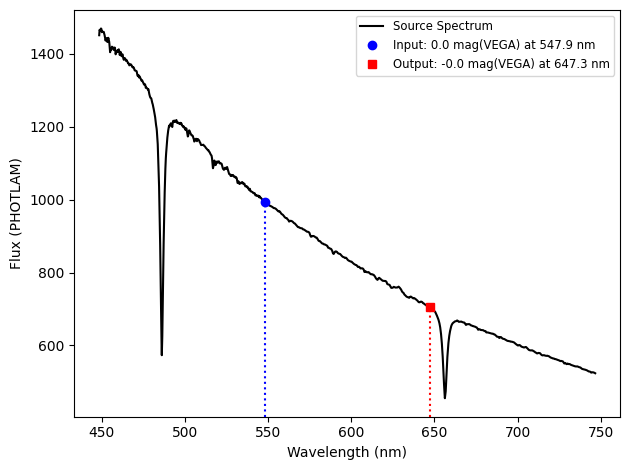

In [16]:
plt.figure()

# Plot spectrum
plt.plot(wavelength_space, scaled_spectrum(wavelength_space,
         flux_unit=plot_unit), c='k', label='Source Spectrum')

# Plot input
plt.plot(wavelength_in.value, plot_flux_in.value,
         marker='o', color=c_in, ls='none',
         label='Input: {:.4} {} at {:.1f} {}'.format(
             float(value_in), str(unit_in), wavelength_in.value, str(wavelength_in.unit)))

# Plot output
plt.plot(wavelength_out.value, plot_flux_out.value,
         marker='s', color=c_out, ls='none',
         label='Output: {:.4} {} at {:.1f} {}'.format(
             float(value_out), str(unit_out), wavelength_out.value, str(wavelength_out.unit)))

# Set heights for dotted lines to markers as % of plot range
bottom, top = plt.ylim()
yrange = top - bottom
inheight = (plot_flux_in.value - bottom) / yrange
outheight = (plot_flux_out.value - bottom) / yrange

# Plot dotted lines to markers
plt.axvline(wavelength_in.to(wavelength_unit).value,
            ymax=inheight, ls=':', c=c_in)
plt.axvline(wavelength_out.to(wavelength_unit).value,
            ymax=outheight, ls=':', c=c_out)

# Miscellaneous
plt.ylabel('Flux ({})'.format(str(plot_unit)))
plt.xlabel('Wavelength ({})'.format(str(wavelength_unit)))
plt.legend(fontsize='small')
plt.tight_layout()

<a id="ex"></a>
## 5. Examples

Here, we provide some examples to illustrate a few of the many conversions which are possible. If desired, you may run an example cell to set the inputs for the tool, then run through the notebook (without running the cells in [Section 2.4](#user)) to see the results. Each cell will define an input, output, and spectrum.

<a id="ex1"></a>
### 5.1. Flux in Jy to AB mag with a flat spectrum in $F_\nu$
Run cell then go to [Section 3](#setting) to convert flux and plot.

In [17]:
# Input: 3631 Jy at 550. nm
value_in = 3631.
unit_in = u.Jy
waveband_in = 550.
wavelength_unit = u.nm

# Output: Johnson V mag (AB)
unit_out = u.ABmag
waveband_out = 'Johnson, V'

# Spectrum: Flat power law in F_nu
pl_index = 0
model = PowerLawFlux1D(amplitude=flux_in, x_0=wavelength_in, alpha=pl_index)
spectrum = SourceSpectrum(model)

<a id="ex2"></a>
### 5.2. Flux in flam to Flux in flam along a blackbody
Run cell then go to [Section 3](#setting) to convert flux and plot.

In [18]:
# Input: 1.234e-8 flam at 500. nm
value_in = 1.234e-8
unit_in = su.FLAM
waveband_in = 500.
wavelength_unit = u.nm

# Output: flam at 800. nm
unit_out = su.FLAM
waveband_out = 800.

# Spectrum: 5800 K blackbody
bb_temp = 5800 * u.K
model = BlackBody1D(bb_temp)
spec = SourceSpectrum(model)

<a id="ex3"></a>
### 5.3. Flux in fnu to flux in photnu, any spectrum (same wavelength)
Run cell then go to [Section 3](#setting) to convert flux and plot. Note the spectrum is irrelevant since conversion is at the same wavelength.

In [19]:
# Input: 1.234e-21 fnu at 686. nm
value_in = 1.234e-21
unit_in = su.FNU
waveband_in = 686.
wavelength_unit = u.nm

# Output: photnu at 686. nm
unit_out = su.PHOTNU
waveband_out = 686.

# Spectrum: 5800 K blackbody
bb_temp = 5800 * u.K
model = BlackBody1D(bb_temp)
spectrum = SourceSpectrum(model)

<a id="ex4"></a>
### 5.4. mag to mag from an HST bandpass to a Johnson bandpass, flat spectrum in $F_\lambda$
Run cell then go to [Section 3](#setting) to convert flux and plot. Note we run `convert_flux` for the power law amplitude to ensure the spectrum is flat in $F_\lambda$ rather than in photlam.

In [20]:
# Input: STmag = 12.240, F606W filter on WFC3 UVIS 2
value_in = 12.240
unit_in = u.STmag
waveband_in = 'wfc3, uvis2, f606w, mjd#59367'
wavelength_unit = u.nm

# Output: Johnson V mag (AB)
unit_out = u.STmag
waveband_out = 'Johnson, V'

# Spectrum: Flat power law in F_lambda
pl_index = 0
model = PowerLawFlux1D(amplitude=convert_flux(
    606 * u.nm, 1., su.FLAM), x_0=606 * u.nm, alpha=pl_index)
spec = SourceSpectrum(model)
model = PowerLawFlux1D(amplitude=flux_in, x_0=wavelength_in, alpha=pl_index)

<a id="conclusion"></a>
## 6. Conclusions

Thank you for walking through this notebook. Now using WFC3 data, you should be more familiar with:

- Performing conversions between various systems of flux and magnitude using the `synphot` and `stsynphot` packages.
- Extrapolating an output flux at a different wavelength than the input flux.
- Adapting a more personalized and streamlined conversion process.

#### Congratulations, you have completed the notebook!

<a id="resources"></a>
## Additional Resources
Below are some additional resources that may be helpful. Please send any questions through the [HST Helpdesk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - see sections 9.5.2 for reference to this notebook
    
<a id="about"></a>
## About this Notebook

**Authors:** Aidan Pidgeon, Joel Green; WFC3 Instrument Team

**Updated on:** 2021-09-13

<a id="cite"></a>
## Citations

If you use `numpy`, `astropy`, `synphot`, or `stsynphot` for published research, please cite the
authors. Follow these links for more information about citing the libraries below:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `synphot`](https://synphot.readthedocs.io/en/latest/)
* [Citing `stsynphot`](https://stsynphot.readthedocs.io/en/latest/index.html)

***
[Top of Page](#title)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 